In [6]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

In [7]:
combined_stocks_df = pd.read_csv("filtered_stocks_combined.csv")

In [8]:
combined_stocks_df

,Date,index,Open,High,Low,Close,Volume,OpenInt,ticker
0,2011-01-03,45725,41.600,42.293,41.600,42.204,123930383,0,AAPL
1,2011-01-04,45726,42.579,42.579,42.023,42.426,86135637,0,AAPL
2,2011-01-05,45727,42.260,42.817,42.196,42.772,70669988,0,AAPL
3,2011-01-06,45728,42.902,42.932,42.632,42.739,83619699,0,AAPL
4,2011-01-07,45729,42.787,43.073,42.503,43.045,86506108,0,AAPL
...,...,...,...,...,...,...,...,...,...
75495,2016-12-23,14745947,87.556,87.625,87.201,87.383,4428429,0,XOM
75496,2016-12-27,14745948,87.499,87.768,87.257,87.423,5100402,0,XOM
75497,2016-12-28,14745949,87.354,87.768,86.949,86.989,6834213,0,XOM
75498,2016-12-29,14745950,86.797,87.277,86.728,87.036,6938299,0,XOM


In [9]:
# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)


# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

# Preview the new structure
stocks_df_leveled.head()


ticker        AAPL                                                  ABT  \
             Close    High     Low    Open OpenInt       Volume   Close   
Date                                                                      
2011-01-03  42.204  42.293  41.600  41.600     0.0  123930383.0  19.358   
2011-01-04  42.426  42.579  42.023  42.579     0.0   86135637.0  19.540   
2011-01-05  42.772  42.817  42.196  42.260     0.0   70669988.0  19.540   
2011-01-06  42.739  42.932  42.632  42.902     0.0   83619699.0  19.500   
2011-01-07  43.045  43.073  42.503  42.787     0.0   86506108.0  19.582   

ticker                              ...     WMT                              \
              High     Low    Open  ...     Low    Open OpenInt      Volume   
Date                                ...                                       
2011-01-03  19.549  19.338  19.549  ...  46.027  46.089     0.0  16789275.0   
2011-01-04  19.561  19.350  19.448  ...  46.139  46.419     0.0  14296931.0   
2011-01-05  19.764  19.460  19.520  ...  46.174  46.539     0.0  16723328.0   
2011-01-06  19.682  19.342  19.634  ...  45.712  46.166     0.0  18335156.0   
2011-01-07  19.615  19.444  19.489  ...  45.698  45.810     0.0   9374462.0   

ticker         XOM                                              
             Close    High     Low    Open OpenInt      Volume  
Date                                                            
2011-01-03  60.341  60.535  59.604  59.668     0.0  28807445.0  
2011-01-04  60.625  60.665  60.235  60.469     0.0  24744869.0  
2011-01-05  60.462  60.600  60.009  60.430     0.0  20448359.0  
2011-01-06  60.853  61.052  60.439  60.625     0.0  27829692.0  
2011-01-07  61.182  61.431  60.777  60.876     0.0  23838996.0  

[5 rows x 300 columns]

In [10]:
# 3. Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
    stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
)

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])


In [11]:
train_df

Close    High     Low    Open  OpenInt       Volume  \
Ticker Date                                                               
AAPL   2011-01-04  42.426  42.579  42.023  42.579      0.0   86135637.0   
       2011-01-05  42.772  42.817  42.196  42.260      0.0   70669988.0   
       2011-01-06  42.739  42.932  42.632  42.902      0.0   83619699.0   
       2011-01-07  43.045  43.073  42.503  42.787      0.0   86506108.0   
       2011-01-10  43.855  43.956  43.179  43.393      0.0  124888228.0   
...                   ...     ...     ...     ...      ...          ...   
XOM    2014-08-04  88.145  88.411  86.542  86.921      0.0   13804459.0   
       2014-08-05  86.445  87.625  86.077  87.492      0.0   14847864.0   
       2014-08-06  87.133  87.723  86.445  86.445      0.0   11264688.0   
       2014-08-07  86.507  87.889  85.944  87.828      0.0   11379351.0   
       2014-08-08  87.800  87.847  86.551  86.947      0.0   12730751.0   

                   log_return  
Ticker Date                    
AAPL   2011-01-04    0.005246  
       2011-01-05    0.008122  
       2011-01-06   -0.000772  
       2011-01-07    0.007134  
       2011-01-10    0.018643  
...                       ...  
XOM    2014-08-04    0.013374  
       2014-08-05   -0.019475  
       2014-08-06    0.007927  
       2014-08-07   -0.007210  
       2014-08-08    0.014836  

[45250 rows x 7 columns]

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Determine ticker and feature levels
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        # Validate 'Close' exists
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        # Lag Features
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        
        # RSI (14-day)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        
        # EMA (10-day)
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        
        # Volatility (5-day)
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Time-based split: 60% train, 20% val, 20% test
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1):
    X, y, today_closes = [], [], []
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    # Select feature columns
    feature_cols = [col for col in df.columns if col[feature_level] in features]
    
    for i in range(window_size, len(df) - target_shift - 1):
        window = df[feature_cols].iloc[i - window_size:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets")
    return X, y, today_closes, num_tickers

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    return val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test

# Test window sizes
window_sizes = range(1, 11)  # Extend to range(1, 31) for full optimization
mpe_scores = {}
for window_size in window_sizes:
    val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test = evaluate_window_size(
        stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level
    )
    if np.isinf(val_mpe):
        continue
    mpe_scores[window_size] = val_mpe
    print(f"Window Size {window_size}: Validation MPE = {val_mpe:.4f}%")

if not mpe_scores:
    raise ValueError("No valid window sizes produced data. Check DataFrame structure and columns.")

best_window_size = min(mpe_scores, key=mpe_scores.get)
print(f"Best Window Size: {best_window_size} with Validation MPE: {mpe_scores[best_window_size]:.4f}%")

# Hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=128, max_value=1024, step=128),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units2', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dense(num_tickers * 2))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Use best window size
val_mpe, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, today_closes_test = evaluate_window_size(
    stocks_df_leveled, best_window_size, ticker_level=ticker_level, feature_level=feature_level
)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='mlp_stock_tuning'
)
tuner.search(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=32,
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Evaluate
y_pred = best_model.predict(X_test_scaled)
mpe = np.mean((y_test - y_pred) / (y_test + 1e-10)) * 100
print(f"Test Mean Percentage Error (MPE): {mpe:.4f}%")

# Directional Accuracy
actual_close = y_test[:, 1::2]
predicted_close = y_pred[:, 1::2]
last_close = today_closes_test
actual_change = actual_close - last_close
predicted_change = predicted_close - last_close
directional_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change))
print(f"Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

Trial 5 Complete [00h 00m 04s]
val_loss: 2334.70947265625

Best val_loss So Far: 2328.3623046875
Total elapsed time: 00h 00m 23s
Best Hyperparameters: {'units1': 256, 'units2': 384, 'learning_rate': 0.001}
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Mean Percentage Error (MPE): -30.2410%
Directional Accuracy for Close Prices: 0.5097


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.layers import Input

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Time-based split: 60% train, 20% val, 20% test
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20):
    X, y, today_closes = [], [], []
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features]
    
    # Start at max_window_size to align samples across window sizes
    for i in range(max_window_size, len(df) - target_shift - 1):
        # Use window_size for features, but align indices
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train and evaluate model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)), # Use Input layer
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Varying Window Method: Train models for multiple window sizes
window_sizes = [1, 5, 10, 20]
max_window_size = max(window_sizes)  # For alignment
models = {}
predictions = {}
mpe_scores = {}
y_test_common = None
today_closes_test_common = None
for window_size in window_sizes:
    val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
        stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
    )
    if np.isinf(val_mpe):
        continue
    models[window_size] = model
    predictions[window_size] = y_test_pred
    mpe_scores[window_size] = val_mpe
    print(f"Window Size {window_size}: Validation MPE = {val_mpe:.4f}%, Test Prediction Shape = {y_test_pred.shape}")
    if y_test_common is None:
        y_test_common = y_test
        today_closes_test_common = today_closes_test

if not mpe_scores:
    raise ValueError("No valid window sizes produced data. Check DataFrame structure and columns.")

# Verify prediction shapes
for ws, pred in predictions.items():
    print(f"Window Size {ws}: Prediction Shape = {pred.shape}")

# Compute weights based on inverse MPE
weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in mpe_scores.items()}
total_weight = sum(weights.values())
weights = {ws: w / total_weight for ws, w in weights.items()}
print("Ensemble weights:", {ws: f"{w:.4f}" for ws, w in weights.items()})

# Combine predictions
ensemble_pred = np.zeros_like(predictions[window_sizes[0]])
for window_size, pred in predictions.items():
    ensemble_pred += weights[window_size] * pred

# Evaluate ensemble
mpe = np.mean((y_test_common - ensemble_pred) / (y_test_common + 1e-10)) * 100
print(f"Varying Window Method Ensemble Test Mean Percentage Error (MPE): {mpe:.4f}%")

# Directional Accuracy
actual_close = y_test_common[:, 1::2]
predicted_close = ensemble_pred[:, 1::2]
last_close = today_closes_test_common
actual_change = actual_close - last_close
predicted_change = predicted_close - last_close
directional_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change))
print(f"Varying Window Method Ensemble Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Hyperparameter tuning on best single model
best_window_size = min(mpe_scores, key=mpe_scores.get)
print(f"Best Single Window Size: {best_window_size} with Validation MPE: {mpe_scores[best_window_size]:.4f}%")

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units1', min_value=128, max_value=1024, step=128),
                    activation='relu'))
    model.add(Dense(hp.Int('units2', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dense(num_tickers * 2))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
    stocks_df_leveled, best_window_size, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size
)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='mlp_stock_tuning'
)
tuner.search(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=32,
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
print(f"Best Hyperparameters for Single Model: {best_hps.values}")

y_pred_single = best_model.predict(X_test_scaled)
mpe_single = np.mean((y_test - y_pred_single) / (y_test + 1e-10)) * 100
print(f"Single Model Test Mean Percentage Error (MPE): {mpe_single:.4f}%")

predicted_close_single = y_pred_single[:, 1::2]
predicted_change_single = predicted_close_single - last_close
directional_accuracy_single = np.mean(np.sign(actual_change) == np.sign(predicted_change_single))
print(f"Single Model Directional Accuracy for Close Prices: {directional_accuracy_single:.4f}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 31)
top_n_windows = 5
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_mpe_scores = {}
    group_models = {}
    group_predictions_test = {}
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if np.isinf(val_mpe):
            continue
        group_mpe_scores[window_size] = val_mpe
        group_models[window_size] = model
        group_predictions_test[window_size] = y_test_pred
        if group_y_test_data is None:
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_mpe_scores:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Select top N windows
    sorted_windows = sorted(group_mpe_scores.items(), key=lambda item: abs(item[1]))
    best_n_windows = dict(sorted_windows[:top_n_windows])

    # Create ensemble
    group_weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in best_n_windows.items()}
    group_total_weight = sum(group_weights.values())
    group_weights = {ws: w / group_total_weight for ws, w in group_weights.items()}

    group_ensemble_pred = np.zeros_like(group_predictions_test[list(best_n_windows.keys())[0]])
    for window_size, weight in group_weights.items():
        group_ensemble_pred += weight * group_predictions_test[window_size]

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 31)
top_n_windows = 5
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_mpe_scores = {}
    group_models = {}
    group_predictions_test = {}
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if np.isinf(val_mpe):
            continue
        group_mpe_scores[window_size] = val_mpe
        group_models[window_size] = model
        group_predictions_test[window_size] = y_test_pred
        if group_y_test_data is None:
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_mpe_scores:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Select top N windows
    sorted_windows = sorted(group_mpe_scores.items(), key=lambda item: abs(item[1]))
    best_n_windows = dict(sorted_windows[:top_n_windows])

    # Create ensemble
    group_weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in best_n_windows.items()}
    group_total_weight = sum(group_weights.values())
    group_weights = {ws: w / group_total_weight for ws, w in group_weights.items()}

    group_ensemble_pred = np.zeros_like(group_predictions_test[list(best_n_windows.keys())[0]])
    for window_size, weight in group_weights.items():
        group_ensemble_pred += weight * group_predictions_test[window_size]

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return None, None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble with Reduced Computational Load
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)  # Limit to 1 through 15
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_models = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_data = None
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        _, model, _, _, _, num_tickers, _, X_val_scaled, X_test_scaled, _, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if model is None:
            continue
        group_models[window_size] = model
        group_predictions_val[window_size] = model.predict(X_val_scaled, verbose=0)
        group_predictions_test[window_size] = y_test_pred
        if group_y_val_data is None:
            group_y_val_data = y_val
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_models:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Stack validation predictions for weight optimization
    val_preds = np.stack([group_predictions_val[ws] for ws in window_range if ws in group_predictions_val], axis=-1)
    y_val_true = group_y_val_data

    # Define loss function for weight optimization (MSE)
    def loss_function(weights):
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse

    # Initial weights (equal)
    initial_weights = np.ones(len(group_models)) / len(group_models)

    # Constraints: weights sum to 1, each weight >= 0
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(len(group_models))]

    # Optimize weights
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    print(f"Optimal weights for Group {group_id}: {optimal_weights}")

    # Create ensemble prediction for the group
    test_preds = np.stack([group_predictions_test[ws] for ws in window_range if ws in group_predictions_test], axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

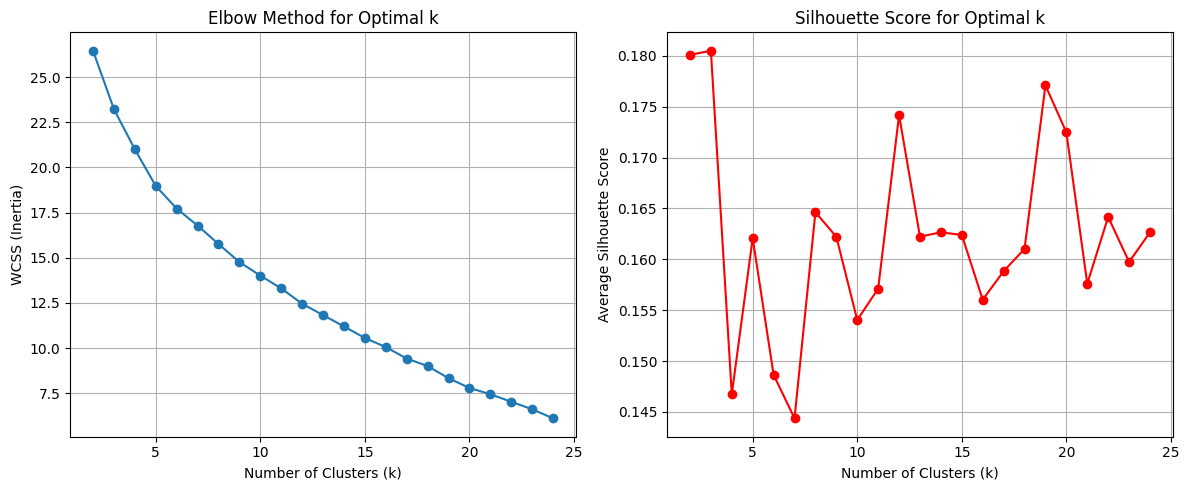

Ticker Groups:
  Group 0: ['QCOM']... (Total: 1)
  Group 1: ['BAC', 'C', 'GS', 'JPM', 'WFC']... (Total: 5)
  Group 2: ['CMCSA', 'DIS', 'HD']... (Total: 3)
  Group 3: ['ABT', 'JNJ', 'SYK']... (Total: 3)
  Group 4: ['WMT']... (Total: 1)
  Group 5: ['ADBE', 'INTU', 'ORCL', 'SPGI', 'TXN']... (Total: 5)
  Group 6: ['NVDA']... (Total: 1)
  Group 7: ['T', 'VZ']... (Total: 2)
  Group 8: ['COST', 'MCD']... (Total: 2)
  Group 9: ['CVX', 'XOM']... (Total: 2)
  Group 10: ['KO', 'PEP', 'PG']... (Total: 3)
  Group 11: ['AMZN', 'GOOGL']... (Total: 2)
  Group 12: ['BSX', 'UNH']... (Total: 2)
  Group 13: ['AAPL']... (Total: 1)
  Group 14: ['AMD']... (Total: 1)
  Group 15: ['CAT', 'GE', 'UNP']... (Total: 3)
  Group 16: ['SMFG']... (Total: 1)
  Group 17: ['AXP', 'DHR', 'HON', 'PGR', 'TMO']... (Total: 5)
  Group 18: ['AMGN', 'LLY', 'MRK', 'PFE']... (Total: 4)
  Group 19: ['CSCO', 'IBM', 'MSFT']... (Total: 3)

--- Group-Specific Optimal Window Ensemble ---

Processing Group 0 (1 tickers)...
Creating rollin

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# --- New Section: Determine Optimal Number of Clusters ---
print("\n--- Determining Optimal Number of Clusters ---")
possible_k_values = range(2, 25) # Example range: Check 2 to 10 clusters
wcss = [] # Within-cluster sum of squares (for Elbow method)
silhouette_scores = [] # Average silhouette scores

print("Calculating WCSS and Silhouette Scores for k=2 to 10...")
for k in possible_k_values:
    kmeans_eval = KMeans(n_clusters=k, random_state=42, n_init=24)
    cluster_labels_eval = kmeans_eval.fit_predict(correlation_matrix)

    # Elbow Method: Inertia (WCSS)
    wcss.append(kmeans_eval.inertia_)

    # Silhouette Score
    # Ensure k > 1 for silhouette score calculation
    if k > 1:
        score = silhouette_score(correlation_matrix, cluster_labels_eval)
        silhouette_scores.append(score)
        print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score={score:.4f}")
    else:
         print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}")


# Plotting the results
plt.figure(figsize=(12, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(possible_k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
# Adjust x-axis for silhouette scores (starts from k=2)
plt.plot(possible_k_values, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()




# K-Means clustering
n_clusters = 20  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return None, None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble with Reduced Computational Load
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)  # Limit to 1 through 15
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_models = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_data = None
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        _, model, _, _, _, num_tickers, _, X_val_scaled, X_test_scaled, _, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if model is None:
            continue
        group_models[window_size] = model
        group_predictions_val[window_size] = model.predict(X_val_scaled, verbose=0)
        group_predictions_test[window_size] = y_test_pred
        if group_y_val_data is None:
            group_y_val_data = y_val
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_models:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Stack validation predictions for weight optimization
    val_preds = np.stack([group_predictions_val[ws] for ws in window_range if ws in group_predictions_val], axis=-1)
    y_val_true = group_y_val_data

    # Define loss function for weight optimization (MSE)
    def loss_function(weights):
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse

    # Initial weights (equal)
    initial_weights = np.ones(len(group_models)) / len(group_models)

    # Constraints: weights sum to 1, each weight >= 0
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(len(group_models))]

    # Optimize weights
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    print(f"Optimal weights for Group {group_id}: {optimal_weights}")

    # Create ensemble prediction for the group
    test_preds = np.stack([group_predictions_test[ws] for ws in window_range if ws in group_predictions_test], axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# K-Means clustering
n_clusters = 5  # Adjustable based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation with ticker subset support
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_tickers * 2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
              epochs=50, batch_size=32, verbose=0)
    return model

# Evaluate window sizes
def evaluate_window_size(df, window_size, ticker_level=0, feature_level=1, max_window_size=20, tickers_to_use=None):
    X, y, today_closes, num_tickers = create_rolling_window_data(
        df, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level, 
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    
    if len(X) == 0 or len(y) == 0:
        print(f"Warning: No valid data for window_size={window_size}. Skipping.")
        return float('inf'), None, None, None, num_tickers, None, None, None, None, None, None, None, None
    
    total_size = len(X)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test, today_closes_test = X[train_size + val_size:], y[train_size + val_size:], today_closes[train_size + val_size:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    
    return val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 31)
top_n_windows = 5
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
all_tickers_ordered = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_mpe_scores = {}
    group_models = {}
    group_predictions_test = {}
    group_y_test_data = None
    group_today_closes_test_data = None

    for window_size in window_range:
        val_mpe, model, X, y, today_closes, num_tickers, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_test_pred, today_closes_test = evaluate_window_size(
            stocks_df_leveled, window_size, ticker_level=ticker_level, feature_level=feature_level, 
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if np.isinf(val_mpe):
            continue
        group_mpe_scores[window_size] = val_mpe
        group_models[window_size] = model
        group_predictions_test[window_size] = y_test_pred
        if group_y_test_data is None:
            group_y_test_data = y_test
            group_today_closes_test_data = today_closes_test

    if not group_mpe_scores:
        print(f"Warning: No valid window sizes for Group {group_id}.")
        continue

    # Select top N windows
    sorted_windows = sorted(group_mpe_scores.items(), key=lambda item: abs(item[1]))
    best_n_windows = dict(sorted_windows[:top_n_windows])

    # Create ensemble
    group_weights = {ws: 1 / max(abs(mpe), 0.01) for ws, mpe in best_n_windows.items()}
    group_total_weight = sum(group_weights.values())
    group_weights = {ws: w / group_total_weight for ws, w in group_weights.items()}

    group_ensemble_pred = np.zeros_like(group_predictions_test[list(best_n_windows.keys())[0]])
    for window_size, weight in group_weights.items():
        group_ensemble_pred += weight * group_predictions_test[window_size]

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_data
    all_group_today_closes[group_id] = group_today_closes_test_data

    # Evaluate group ensemble
    group_mpe = np.mean((group_y_test_data - group_ensemble_pred) / (group_y_test_data + 1e-10)) * 100
    group_actual_close = group_y_test_data[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    group_actual_change = group_actual_close - group_last_close
    group_predicted_change = group_predicted_close - group_last_close
    group_da = np.mean(np.sign(group_actual_change) == np.sign(group_predicted_change))
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
num_test_samples = list(all_group_predictions.values())[0].shape[0]
num_total_tickers = len(all_tickers_ordered)
final_ensemble_pred = np.zeros((num_test_samples, num_total_tickers * 2))
final_y_test = np.zeros((num_test_samples, num_total_tickers * 2))
final_today_closes = np.zeros((num_test_samples, num_total_tickers))

for group_id, group_tickers in groups.items():
    if group_id not in all_group_predictions:
        continue
    group_pred = all_group_predictions[group_id]
    group_y = all_group_y_test[group_id]
    group_closes = all_group_today_closes[group_id]
    for i, ticker in enumerate(group_tickers):
        original_idx = ticker_to_index_map[ticker]
        final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
        final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
        final_y_test[:, original_idx * 2] = group_y[:, i * 2]
        final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
        final_today_closes[:, original_idx] = group_closes[:, i]

# Evaluate Final Ensemble
final_mpe = np.mean((final_y_test - final_ensemble_pred) / (final_y_test + 1e-10)) * 100
print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")

final_actual_close = final_y_test[:, 1::2]
final_predicted_close = final_ensemble_pred[:, 1::2]
final_last_close = final_today_closes
final_actual_change = final_actual_close - final_last_close
final_predicted_change = final_predicted_close - final_last_close
directional_accuracy = np.mean(np.sign(final_actual_change) == np.sign(final_predicted_change))
print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'High', 'Low', 'Open', 'OpenInt', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' dropped successfully.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'High', 'Low', 'Open', 

Logistic Regression Conunterpart

/var/folders/7r/9fzqnfrn3gb83dkk5f562fbh0000gp/T/ipykernel_87340/1672379435.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Year'] = test_df['Date'].dt.year


Rolling Window Results:
Accuracy: 0.7663
F1 Score: 0.7778
AUC-ROC: 0.8264

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5391          1903
Actual Up              1623          6173


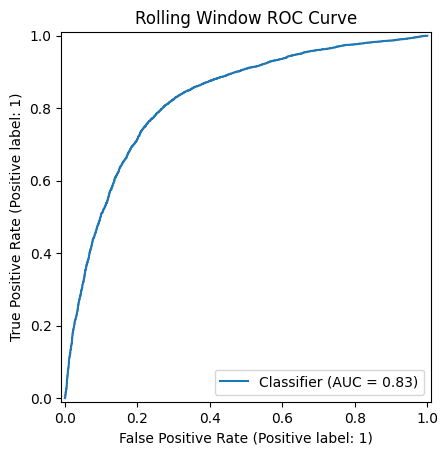

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

# Create target variable (1 if current close > previous close)
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Volume']

# Split into train and test, maintaining temporal consistency
n_total = len(df)
train_size = int(0.8 * n_total)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Add year column for grouping
test_df['Year'] = test_df['Date'].dt.year
unique_years = sorted(test_df['Year'].unique())

all_y_true = []
all_y_pred = []
all_y_proba = []
all_test_dates = []

for idx, year in enumerate(unique_years):
    # For each year in test set:
    year_mask = test_df['Year'] == year
    year_test = test_df[year_mask].reset_index(drop=True)
    if idx == 0:
        # For the first year, use the initial 80% train set
        year_train = train_df.copy()
    else:
        # For subsequent years, use 80% of all data up to the start of this year
        cutoff_date = year_test['Date'].min()
        up_to_year = df[df['Date'] < cutoff_date]
        year_train_size = int(0.8 * len(up_to_year))
        year_train = up_to_year.iloc[:year_train_size]

    # Prepare train data
    X_train = year_train[features]
    y_train = year_train['target']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Use time series split for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Train model ONCE for the year using time series aware CV
    model = LogisticRegressionCV(
        Cs=10,
        cv=tscv,
        scoring='roc_auc',
        random_state=42,
        max_iter=1000
    )
    model.fit(X_train_scaled, y_train)

    # Rolling window prediction for this year
    test_size = 10
    n_test = len(year_test)
    start = 0
    while start + test_size <= n_test:
        test_batch = year_test.iloc[start:start+test_size]
        X_test_batch = test_batch[features]
        y_test_batch = test_batch['target']

        # Use scaler fitted on train
        X_test_batch_scaled = scaler.transform(X_test_batch)

        # Predict
        y_pred_batch = model.predict(X_test_batch_scaled)
        y_proba_batch = model.predict_proba(X_test_batch_scaled)[:, 1]

        # Store results
        all_y_true.extend(y_test_batch)
        all_y_pred.extend(y_pred_batch)
        all_y_proba.extend(y_proba_batch)
        all_test_dates.extend(test_batch['Date'])

        start += test_size

# Evaluation
accuracy = accuracy_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)
auc = roc_auc_score(all_y_true, all_y_proba)
cm = confusion_matrix(all_y_true, all_y_pred)

print(f"Rolling Window Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# ROC Curve
RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling Window ROC Curve')
plt.show()

Further MLP implementation

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, silhouette_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# Determine Optimal Number of Clusters
print("\n--- Determining Optimal Number of Clusters ---")
max_k = min(25, correlation_matrix.shape[0] - 1)  # Ensure k < n_samples
min_k = 2

if max_k < min_k:
    print(f"Warning: Not enough tickers ({correlation_matrix.shape[0]}) for clustering evaluation (min_k={min_k}, max_k={max_k}). Defaulting to 1 cluster.")
    best_k = 1
    silhouette_scores_dict = {}
else:
    possible_k_values = range(min_k, max_k + 1)
    wcss = []
    silhouette_scores_dict = {}

    print(f"Calculating WCSS and Silhouette Scores for k={min(possible_k_values)} to {max(possible_k_values)}...")
    for k in possible_k_values:
        kmeans_eval = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels_eval = kmeans_eval.fit_predict(correlation_matrix)
        wcss.append(kmeans_eval.inertia_)
        if k > 1 and len(set(cluster_labels_eval)) > 1:
            try:
                score = silhouette_score(correlation_matrix, cluster_labels_eval)
                silhouette_scores_dict[k] = score
                print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score={score:.4f}")
            except ValueError as e:
                print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score: Error ({e})")
                silhouette_scores_dict[k] = -1
        elif k > 1:
            print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score: Not calculated (only 1 cluster found).")
            silhouette_scores_dict[k] = -1
        else:
            print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}")

    # Plotting the results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(possible_k_values, wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.xticks(list(possible_k_values))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    valid_k_for_silhouette = sorted(silhouette_scores_dict.keys())
    valid_silhouette_scores = [silhouette_scores_dict[k] for k in valid_k_for_silhouette]
    if valid_silhouette_scores:
        plt.plot(valid_k_for_silhouette, valid_silhouette_scores, marker='o', color='r')
        best_k_silhouette = max(silhouette_scores_dict, key=silhouette_scores_dict.get)
        plt.axvline(x=best_k_silhouette, color='grey', linestyle='--', label=f'Best k (Silhouette) = {best_k_silhouette}')
        plt.legend()
        best_k = best_k_silhouette
        print(f"\nSelected n_clusters = {best_k} based on max silhouette score ({silhouette_scores_dict[best_k]:.4f}).")
    else:
        plt.text(0.5, 0.5, 'Silhouette scores could not be calculated.', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        best_k = 5  # Default if silhouette fails
        print(f"\nWarning: Silhouette scores unavailable. Using default n_clusters = {best_k}. Please review the Elbow plot.")

    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.xticks(list(possible_k_values))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('cluster_evaluation.png')
    plt.close()

# K-Means clustering with best_k
n_clusters = best_k
if n_clusters > 0:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(correlation_matrix)
    ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
    groups = {i: [] for i in range(n_clusters)}
    for ticker, group_id in ticker_groups.items():
        if group_id in groups:
            groups[group_id].append(ticker)
        else:
            print(f"Warning: Ticker {ticker} assigned to unexpected cluster label {group_id}. Skipping.")
    groups = {gid: tkrs for gid, tkrs in groups.items() if tkrs}
    print(f"\nCreated {len(groups)} non-empty groups using k={n_clusters}.")
else:
    print("Clustering skipped as n_clusters <= 0.")
    groups = {0: tickers_for_clustering}

print("\nTicker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)
train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = tickers_to_use
    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        X.append(window.values.flatten())
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if len(targets) == num_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X, y, today_closes = np.array(X), np.array(y), np.array(today_closes)
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(256, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(num_tickers * 2)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    print(f"Training model with Dropout={dropout_rate}, L2 Reg={l2_reg}...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    print(f"Finished training after {len(history.epoch)} epochs. Best val_loss: {min(history.history.get('val_loss', [np.inf])):.4f}")
    return model

# Evaluate window sizes (Refactored to prevent data leakage)
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    print(f"Creating windows for train/val/test sets (window_size={window_size})...")
    X_train, y_train, _, num_tickers_train = create_rolling_window_data(
        train_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_val, y_val, _, num_tickers_val = create_rolling_window_data(
        val_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_test, y_test, today_closes_test, num_tickers_test = create_rolling_window_data(
        test_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    if not (num_tickers_train == num_tickers_val == num_tickers_test):
        print(f"Warning: Inconsistent number of tickers across splits for window {window_size}. Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None
    num_tickers = num_tickers_train
    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Warning: Insufficient data after windowing for train/val/test split (window_size={window_size}). Skipping.")
        return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None, None, None
    scaler = StandardScaler()
    print(f"Scaling data (fitting on {X_train.shape[0]} training samples)...")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001)
    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    print(f"Window={window_size}, Validation MPE: {val_mpe:.4f}%")
    y_test_pred = model.predict(X_test_scaled, verbose=0)
    return val_mpe, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred, y_test_pred, today_closes_test, num_tickers

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
group_scalers = {}
group_models_dict = {}
all_tickers_ordered = sorted([t for t in stocks_df_leveled.columns.levels[ticker_level] if str(t).lower() not in known_features])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}
num_total_tickers = len(all_tickers_ordered)

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    if not group_tickers:
        print("Skipping empty group.")
        continue
    group_cols_index = []
    feature_names = stocks_df_leveled.columns.levels[feature_level]
    for ticker in group_tickers:
        for feature in feature_names:
            col = (ticker, feature) if ticker_level == 0 else (feature, ticker)
            if col in stocks_df_leveled.columns:
                group_cols_index.append(col)
    train_df_group = train_df.loc[:, train_df.columns.isin(group_cols_index)]
    val_df_group = val_df.loc[:, val_df.columns.isin(group_cols_index)]
    test_df_group = test_df.loc[:, test_df.columns.isin(group_cols_index)]
    group_models = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_actual = None
    group_y_test_actual = None
    group_today_closes_test_data = None
    for window_size in window_range:
        print(f"Evaluating Group {group_id}, Window Size {window_size}...")
        val_mpe, model, scaler, _, X_val_scaled, X_test_scaled, _, y_val, y_test, y_val_pred, y_test_pred, today_closes_test, num_tickers = evaluate_window_size(
            train_df_group, val_df_group, test_df_group, window_size, ticker_level=ticker_level, feature_level=feature_level,
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )
        if model is None:
            print(f"Skipping window size {window_size} for Group {group_id} due to evaluation issues.")
            continue
        group_models[window_size] = model
        group_scalers[window_size] = scaler
        group_predictions_val[window_size] = y_val_pred
        group_predictions_test[window_size] = y_test_pred
        if group_y_val_actual is None and y_val is not None:
            group_y_val_actual = y_val
        if group_y_test_actual is None and y_test is not None:
            group_y_test_actual = y_test
        if group_today_closes_test_data is None and today_closes_test is not None:
            group_today_closes_test_data = today_closes_test
    if not group_models:
        print(f"Warning: No valid models trained for Group {group_id}. Skipping ensemble.")
        continue
    if group_y_val_actual is None or group_y_test_actual is None:
        print(f"Warning: Target data missing for Group {group_id}. Skipping ensemble.")
        continue
    print(f"\nOptimizing ensemble weights for Group {group_id} using {len(group_models)} models...")
    valid_window_sizes = sorted(group_predictions_val.keys())
    val_preds_list = [group_predictions_val[ws] for ws in valid_window_sizes]
    first_shape = val_preds_list[0].shape
    if not all(p.shape == first_shape for p in val_preds_list):
        print(f"Error: Validation predictions have inconsistent shapes in Group {group_id}. Skipping weight optimization.")
        continue
    val_preds = np.stack(val_preds_list, axis=-1)
    y_val_true = group_y_val_actual
    def loss_function(weights):
        weights = weights + 1e-10
        weights /= np.sum(weights)
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse
    num_models_in_ensemble = len(valid_window_sizes)
    initial_weights = np.ones(num_models_in_ensemble) / num_models_in_ensemble
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(num_models_in_ensemble)]
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False})
    if result.success:
        optimal_weights = result.x
        optimal_weights = np.maximum(0, optimal_weights)
        optimal_weights /= np.sum(optimal_weights)
        print(f"Optimal weights for Group {group_id}:")
        for ws, w in zip(valid_window_sizes, optimal_weights):
            print(f"  Window {ws}: {w:.4f}")
    else:
        print(f"Warning: Weight optimization failed for Group {group_id}. Using equal weights.")
        optimal_weights = initial_weights
    print(f"Creating ensemble prediction for Group {group_id} test set...")
    test_preds_list = [group_predictions_test[ws] for ws in valid_window_sizes]
    if not all(p.shape == test_preds_list[0].shape for p in test_preds_list):
        print(f"Error: Test predictions have inconsistent shapes in Group {group_id}. Skipping ensemble prediction.")
        continue
    test_preds = np.stack(test_preds_list, axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)
    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_actual
    all_group_today_closes[group_id] = group_today_closes_test_data
    group_models_dict[group_id] = group_models
    print(f"Evaluating ensemble performance for Group {group_id}...")
    group_mpe = np.mean((group_y_test_actual - group_ensemble_pred) / (group_y_test_actual + 1e-10)) * 100
    group_actual_close = group_y_test_actual[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]
    group_last_close = group_today_closes_test_data
    if group_actual_close.shape == group_last_close.shape and group_predicted_close.shape == group_last_close.shape:
        group_actual_change = group_actual_close - group_last_close
        group_predicted_change = group_predicted_close - group_last_close
        valid_comparison = (np.abs(group_actual_change) > 1e-9) & (np.abs(group_predicted_change) > 1e-9)
        group_da = np.mean(np.sign(group_actual_change[valid_comparison]) == np.sign(group_predicted_change[valid_comparison])) if np.any(valid_comparison) else np.nan
    else:
        print(f"Warning: Shape mismatch for DA calculation in Group {group_id}.")
        group_da = np.nan
    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {group_da:.4f}")

# Combine Group Predictions
if not all_group_predictions:
    print("\nError: No group predictions were generated. Cannot combine or evaluate final ensemble.")
else:
    first_valid_group_id = next(iter(all_group_predictions))
    num_test_samples = all_group_predictions[first_valid_group_id].shape[0]
    final_ensemble_pred = np.full((num_test_samples, num_total_tickers * 2), np.nan)
    final_y_test = np.full((num_test_samples, num_total_tickers * 2), np.nan)
    final_today_closes = np.full((num_test_samples, num_total_tickers), np.nan)
    for group_id, group_tickers in groups.items():
        if group_id not in all_group_predictions:
            continue
        group_pred = all_group_predictions[group_id]
        group_y = all_group_y_test[group_id]
        group_closes = all_group_today_closes.get(group_id)
        for i, ticker in enumerate(group_tickers):
            original_idx = ticker_to_index_map[ticker]
            if i * 2 + 1 >= group_pred.shape[1] or (group_closes is not None and i >= group_closes.shape[1]):
                continue
            final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
            final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
            final_y_test[:, original_idx * 2] = group_y[:, i * 2]
            final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
            if group_closes is not None:
                final_today_closes[:, original_idx] = group_closes[:, i]
    valid_mpe_mask = ~np.isnan(final_y_test) & ~np.isnan(final_ensemble_pred) & (np.abs(final_y_test) > 1e-10)
    if np.any(valid_mpe_mask):
        final_mpe = np.mean(((final_y_test[valid_mpe_mask] - final_ensemble_pred[valid_mpe_mask]) / final_y_test[valid_mpe_mask])) * 100
        print(f"\nGroup-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")
    else:
        print("\nWarning: Could not calculate final MPE (no valid data points).")
        final_mpe = np.nan
    final_actual_close = final_y_test[:, 1::2]
    final_predicted_close = final_ensemble_pred[:, 1::2]
    final_last_close = final_today_closes
    valid_da_mask = ~np.isnan(final_actual_close) & ~np.isnan(final_predicted_close) & ~np.isnan(final_last_close)
    if final_actual_close.shape == final_last_close.shape and final_predicted_close.shape == final_last_close.shape and np.any(valid_da_mask):
        final_actual_change = final_actual_close - final_last_close
        final_predicted_change = final_predicted_close - final_last_close
        da_calc_mask = valid_da_mask & (np.abs(final_actual_change) > 1e-9) & (np.abs(final_predicted_change) > 1e-9)
        if np.any(da_calc_mask):
            directional_accuracy = np.mean(np.sign(final_actual_change[da_calc_mask]) == np.sign(final_predicted_change[da_calc_mask]))
            print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")
        else:
            print("Warning: Could not calculate final DA (no valid non-zero changes).")
            directional_accuracy = np.nan
    else:
        print("Warning: Shape mismatch or NaN values preventing final DA calculation.")
        directional_accuracy = np.nan

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'EMA_10', 'High', 'Low', 'Open', 'RSI', 'Volume', 'lag_1_close', 'lag_2_close', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' not found in columns. Proceeding without dropping.
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'EMA_

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, silhouette_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Debug: Print MultiIndex structure
print("Column MultiIndex structure:")
print("Level 0:", stocks_df_leveled.columns.levels[0].tolist())
print("Level 1:", stocks_df_leveled.columns.levels[1].tolist())
print("Sample columns:", stocks_df_leveled.columns[:10].tolist())

# Confirm (feature, ticker) order
known_features = {'Close', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'close', 'open', 'high', 'low', 'volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'returns', 'volatility_5'}
known_tickers = {'AAPL', 'MSFT', 'GOOG', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'}
if any(f in stocks_df_leveled.columns.levels[0] for f in known_features):
    ticker_level = 1
    feature_level = 0
    print("Detected: Features in level 0, tickers in level 1")
else:
    ticker_level = 0
    feature_level = 1
    print("Detected: Tickers in level 0, features in level 1")

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    print("'OpenInt' dropped successfully.")
else:
    print("'OpenInt' not found in columns. Proceeding without dropping.")

# Feature engineering
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            df[col]
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()
        df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)] = df[col].pct_change()
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'returns') if ticker_level == 0 else ('returns', ticker)].rolling(window=5).std()
    
    # Impute missing values before dropping
    df = df.fillna(method='ffill').fillna(method='bfill')
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    return df.dropna()

# Apply feature engineering
print("Applying feature engineering to stocks_df_leveled...")
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# Time-based split
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)
train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]
print(f"Data split into Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Correlation-Based Clustering
print("\n--- Correlation-Based Clustering ---")
tickers_for_clustering = [t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features]
print(f"Tickers for clustering: {tickers_for_clustering}")

# Select 'returns' columns
if feature_level == 0:  # Features level 0, tickers level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice['returns', tickers_for_clustering]]
    returns_df.columns = returns_df.columns.droplevel(0)  # Drop 'returns'
else:  # Tickers level 0, features level 1
    returns_df = stocks_df_leveled.loc[:, pd.IndexSlice[tickers_for_clustering, 'returns']]
    returns_df.columns = returns_df.columns.droplevel(1)  # Drop 'returns'

# Calculate correlation matrix
correlation_matrix = returns_df.corr().fillna(0)

# Determine Optimal Number of Clusters
print("\n--- Determining Optimal Number of Clusters ---")
max_k = min(25, correlation_matrix.shape[0] - 1)
min_k = 2
if max_k < min_k:
    print(f"Warning: Not enough tickers ({correlation_matrix.shape[0]}) for clustering. Defaulting to 1 cluster.")
    n_clusters = 1
    silhouette_scores_dict = {}
else:
    possible_k_values = range(min_k, max_k + 1)
    wcss = []
    silhouette_scores_dict = {}
    print(f"Calculating WCSS and Silhouette Scores for k={min_k} to {max_k}...")
    for k in possible_k_values:
        kmeans_eval = KMeans(n_clusters=k, random_state=42, n_init=24)
        cluster_labels_eval = kmeans_eval.fit_predict(correlation_matrix)
        wcss.append(kmeans_eval.inertia_)
        if k > 1 and len(set(cluster_labels_eval)) > 1:
            score = silhouette_score(correlation_matrix, cluster_labels_eval)
            silhouette_scores_dict[k] = score
            print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score={score:.4f}")
        else:
            silhouette_scores_dict[k] = -1
            print(f"  k={k}, WCSS={kmeans_eval.inertia_:.2f}, Silhouette Score: Not calculated.")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(possible_k_values, wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    valid_k = [k for k in silhouette_scores_dict if silhouette_scores_dict[k] > -1]
    valid_scores = [silhouette_scores_dict[k] for k in valid_k]
    if valid_scores:
        plt.plot(valid_k, valid_scores, marker='o', color='r')
        best_k = max(silhouette_scores_dict, key=silhouette_scores_dict.get)
        plt.axvline(x=best_k, color='grey', linestyle='--', label=f'Best k = {best_k}')
        plt.legend()
    else:
        best_k = 5  # Default if silhouette fails
        plt.text(0.5, 0.5, 'Silhouette scores unavailable.', horizontalalignment='center', verticalalignment='center')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('cluster_evaluation.png')
    plt.close()
    n_clusters = best_k  # Use optimal k

# K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Create groups
ticker_groups = {ticker: label for ticker, label in zip(tickers_for_clustering, cluster_labels)}
groups = {i: [] for i in range(n_clusters)}
for ticker, group_id in ticker_groups.items():
    groups[group_id].append(ticker)
groups = {gid: tkrs for gid, tkrs in groups.items() if tkrs}

print("Ticker Groups:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {tickers_in_group[:5]}... (Total: {len(tickers_in_group)})")

# Rolling window data creation
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    if len(df) < max_window_size + target_shift + 1:
        print(f"Warning: DataFrame too small (rows: {len(df)}) for window_size={window_size}, max_window_size={max_window_size}. Returning empty arrays.")
        return np.array([]), np.array([]), np.array([]), 0

    X, y, today_closes = [], [], []
    if tickers_to_use is None:
        tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    else:
        tickers = [t for t in tickers_to_use if t in df.columns.levels[ticker_level]]
    
    if not tickers:
        print("Warning: No valid tickers found in the DataFrame.")
        return np.array([]), np.array([]), np.array([]), 0

    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers with features: {features}")
    
    if not isinstance(df.columns, pd.MultiIndex):
        print("Error: DataFrame must have a MultiIndex with at least two levels.")
        return np.array([]), np.array([]), np.array([]), num_tickers
    
    feature_cols = [col for col in df.columns if col[feature_level] in features and col[ticker_level] in tickers]
    if not feature_cols:
        print("Warning: No feature columns available for the specified tickers.")
        return np.array([]), np.array([]), np.array([]), num_tickers
    
    for i in range(max_window_size, len(df) - target_shift - 1):
        start_idx = i - window_size
        if start_idx < 0:
            continue
        window = df[feature_cols].iloc[start_idx:i]
        if window.isna().any().any():
            continue
        X.append(window.values.flatten())
        next_day = df.iloc[i + target_shift]
        today = df.iloc[i]
        targets = []
        closes = []
        valid_tickers = 0
        for ticker in tickers:
            try:
                open_col = (ticker, 'Open') if ticker_level == 0 else ('Open', ticker)
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                if open_col not in df.columns or close_col not in df.columns:
                    continue
                targets.append(next_day[open_col])
                targets.append(next_day[close_col])
                closes.append(today[close_col])
                valid_tickers += 1
            except KeyError as e:
                print(f"Warning: Skipping ticker {ticker} due to missing column {e}.")
                continue
        if valid_tickers > 0 and len(targets) == valid_tickers * 2:
            y.append(targets)
            today_closes.append(closes)
    
    X = np.array(X)
    y = np.array(y)
    today_closes = np.array(today_closes)
    num_tickers = valid_tickers  # Update based on actual valid tickers
    if len(X) == 0 or len(y) == 0:
        print("Warning: No valid windows created.")
        return np.array([]), np.array([]), np.array([]), num_tickers
    print(f"Created {len(X)} windows with {len(y)} targets for window_size={window_size}")
    return X, y, today_closes, num_tickers

# Train model
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(256, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(num_tickers * 2)  # Output layer for Open and Close for each ticker
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    print(f"Training model with Dropout={dropout_rate}, L2 Reg={l2_reg}...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    print(f"Finished training after {len(history.epoch)} epochs. Best val_loss: {min(history.history.get('val_loss', [np.inf])):.4f}")
    return model

# Evaluate window sizes
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    print(f"Creating windows for train/val/test sets (window_size={window_size})...")
    X_train, y_train, _, num_tickers_train = create_rolling_window_data(
        train_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_val, y_val, _, num_tickers_val = create_rolling_window_data(
        val_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_test, y_test, today_closes_test, num_tickers_test = create_rolling_window_data(
        test_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )

    if not (num_tickers_train == num_tickers_val == num_tickers_test):
        print(f"Warning: Inconsistent number of tickers across splits for window {window_size} (train: {num_tickers_train}, val: {num_tickers_val}, test: {num_tickers_test}). Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, None, None

    num_tickers = num_tickers_train
    if num_tickers == 0:
        print(f"Warning: No valid tickers for window_size={window_size}. Skipping.")
        return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Warning: Insufficient data after windowing for train/val/test split (window_size={window_size}). Skipping.")
        return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None

    scaler = StandardScaler()
    print(f"Scaling data (fitting on {X_train.shape[0]} training samples)...")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)

    y_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mpe = np.mean((y_val - y_val_pred) / (y_val + 1e-10)) * 100
    print(f"Window={window_size}, Validation MPE: {val_mpe:.4f}%")

    y_test_pred = model.predict(X_test_scaled, verbose=0)

    return val_mpe, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred, y_test_pred, today_closes_test, num_tickers

# Group-Specific Optimal Window Ensemble
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)
print(f"window_range: {list(window_range)}, max(window_range): {max(window_range)}")
all_group_predictions = {}
all_group_y_test = {}
all_group_today_closes = {}
group_final_mpe = {}
group_final_da = {}
group_models_dict = {}
all_tickers_ordered = sorted([t for t in stocks_df_leveled.columns.levels[ticker_level] if str(t).lower() not in known_features])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}
num_total_tickers = len(all_tickers_ordered)

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers: {group_tickers})...")
    if not group_tickers:
        print("Skipping empty group.")
        continue

    group_cols_index = []
    feature_names = stocks_df_leveled.columns.levels[feature_level]
    for ticker in group_tickers:
        for feature in feature_names:
            col = (ticker, feature) if ticker_level == 0 else (feature, ticker)
            if col in stocks_df_leveled.columns:
                group_cols_index.append(col)

    train_cols = [col for col in group_cols_index if col in train_df.columns]
    val_cols = [col for col in group_cols_index if col in val_df.columns]
    test_cols = [col for col in group_cols_index if col in test_df.columns]

    if not train_cols or not val_cols or not test_cols:
        print(f"Warning: Could not find necessary columns for group {group_id} in train/val/test splits. Skipping group.")
        continue

    train_df_group = train_df[train_cols]
    val_df_group = val_df[val_cols]
    test_df_group = test_df[test_cols]

    print(f"Group {group_id} train_df_group rows: {len(train_df_group)}, columns: {len(train_df_group.columns)}")
    print(f"Group {group_id} val_df_group rows: {len(val_df_group)}, columns: {len(val_df_group.columns)}")
    print(f"Group {group_id} test_df_group rows: {len(test_df_group)}, columns: {len(test_df_group.columns)}")

    if train_df_group.empty or val_df_group.empty or test_df_group.empty:
        print(f"Warning: Empty DataFrame for Group {group_id}. Skipping.")
        continue

    group_models = {}
    group_scalers = {}
    group_predictions_val = {}
    group_predictions_test = {}
    group_y_val_actual = None
    group_y_test_actual = None
    group_today_closes_test_data = None

    for window_size in window_range:
        print(f"Evaluating Group {group_id}, Window Size {window_size}...")
        val_mpe, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred, y_test_pred, today_closes_test, num_tickers = evaluate_window_size(
            train_df_group, val_df_group, test_df_group, window_size, ticker_level=ticker_level, feature_level=feature_level,
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )

        if model is None:
            print(f"Skipping window size {window_size} for Group {group_id} due to evaluation issues.")
            continue

        group_models[window_size] = model
        group_scalers[window_size] = scaler
        group_predictions_val[window_size] = y_val_pred
        group_predictions_test[window_size] = y_test_pred

        if group_y_val_actual is None and y_val is not None:
            group_y_val_actual = y_val
        if group_y_test_actual is None and y_test is not None:
            group_y_test_actual = y_test
        if group_today_closes_test_data is None and today_closes_test is not None:
            group_today_closes_test_data = today_closes_test

    if not group_models:
        print(f"Warning: No valid models trained for Group {group_id}. Skipping ensemble.")
        continue
    if group_y_val_actual is None or group_y_test_actual is None:
        print(f"Warning: Actual target data missing for Group {group_id}. Skipping ensemble.")
        continue

    print(f"\nOptimizing ensemble weights for Group {group_id} using {len(group_models)} models...")
    valid_window_sizes = sorted(group_predictions_val.keys())
    val_preds_list = [group_predictions_val[ws] for ws in valid_window_sizes]

    if not val_preds_list:
        print(f"Error: No validation predictions available for Group {group_id}. Skipping.")
        continue
    first_shape = val_preds_list[0].shape
    if group_y_val_actual.shape != first_shape:
        print(f"Error: Shape mismatch between actual validation targets {group_y_val_actual.shape} and predictions {first_shape} in Group {group_id}. Skipping.")
        continue
    if not all(p.shape == first_shape for p in val_preds_list):
        print(f"Error: Validation predictions have inconsistent shapes in Group {group_id}. Skipping weight optimization.")
        continue

    val_preds = np.stack(val_preds_list, axis=-1)
    y_val_true = group_y_val_actual

    def loss_function(weights):
        weights = weights + 1e-10
        weights /= np.sum(weights)
        weighted_pred = np.sum(val_preds * weights[None, None, :], axis=-1)
        mse = np.mean((y_val_true - weighted_pred) ** 2)
        return mse

    num_models_in_ensemble = len(valid_window_sizes)
    initial_weights = np.ones(num_models_in_ensemble) / num_models_in_ensemble
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(num_models_in_ensemble)]
    result = minimize(loss_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False})

    if result.success:
        optimal_weights = result.x
        optimal_weights = np.maximum(0, optimal_weights)
        optimal_weights /= np.sum(optimal_weights)
        print(f"Optimal weights for Group {group_id}:")
        for ws, w in zip(valid_window_sizes, optimal_weights):
            print(f"  Window {ws}: {w:.4f}")
    else:
        print(f"Warning: Weight optimization failed for Group {group_id} (Message: {result.message}). Using equal weights.")
        optimal_weights = initial_weights

    print(f"Creating ensemble prediction for Group {group_id} test set...")
    test_preds_list = [group_predictions_test[ws] for ws in valid_window_sizes]

    if not test_preds_list:
        print(f"Error: No test predictions available for Group {group_id}. Skipping.")
        continue
    first_test_shape = test_preds_list[0].shape
    if group_y_test_actual.shape != first_test_shape:
        print(f"Error: Shape mismatch between actual test targets {group_y_test_actual.shape} and predictions {first_test_shape} in Group {group_id}. Skipping.")
        continue
    if not all(p.shape == first_test_shape for p in test_preds_list):
        print(f"Error: Test predictions have inconsistent shapes in Group {group_id}. Skipping ensemble prediction.")
        continue

    test_preds = np.stack(test_preds_list, axis=-1)
    group_ensemble_pred = np.sum(test_preds * optimal_weights[None, None, :], axis=-1)

    all_group_predictions[group_id] = group_ensemble_pred
    all_group_y_test[group_id] = group_y_test_actual
    if group_today_closes_test_data is not None:
        all_group_today_closes[group_id] = group_today_closes_test_data
    else:
        print(f"Warning: today_closes_test data missing for group {group_id}. DA calculation might fail.")
        all_group_today_closes[group_id] = None

    group_models_dict[group_id] = group_models

    print(f"Evaluating ensemble performance for Group {group_id}...")
    group_mpe = np.mean((group_y_test_actual - group_ensemble_pred) / (group_y_test_actual + 1e-10)) * 100
    group_actual_close = group_y_test_actual[:, 1::2]
    group_predicted_close = group_ensemble_pred[:, 1::2]

    if all_group_today_closes.get(group_id) is not None:
        group_last_close = all_group_today_closes[group_id]
        if group_actual_close.shape == group_last_close.shape and group_predicted_close.shape == group_last_close.shape:
            group_actual_change = group_actual_close - group_last_close
            group_predicted_change = group_predicted_close - group_last_close
            valid_comparison = (np.abs(group_actual_change) > 1e-9) & (np.abs(group_predicted_change) > 1e-9)
            group_da = np.mean(np.sign(group_actual_change[valid_comparison]) == np.sign(group_predicted_change[valid_comparison])) if np.any(valid_comparison) else np.nan
        else:
            print(f"Warning: Shape mismatch for DA calculation in Group {group_id}.")
            print(f"  Actual Close Shape: {group_actual_close.shape}")
            print(f"  Predicted Close Shape: {group_predicted_close.shape}")
            print(f"  Last Close Shape: {group_last_close.shape if group_last_close is not None else 'None'}")
            group_da = np.nan
    else:
        print(f"Warning: Cannot calculate DA for Group {group_id} due to missing today's close data.")
        group_da = np.nan

    group_final_mpe[group_id] = group_mpe
    group_final_da[group_id] = group_da
    print(f"  Group {group_id} Ensemble: Test MPE = {group_mpe:.4f}%, DA = {'N/A' if np.isnan(group_da) else f'{group_da:.4f}'}")

# Combine Group Predictions
if not all_group_predictions:
    print("\nError: No group predictions were generated. Cannot combine or evaluate final ensemble.")
else:
    try:
        first_valid_group_id = next(iter(all_group_predictions))
        num_test_samples = all_group_predictions[first_valid_group_id].shape[0]
    except StopIteration:
        print("\nError: Could not determine number of test samples. No valid group predictions found.")
        num_test_samples = 0

    if num_test_samples > 0:
        final_ensemble_pred = np.full((num_test_samples, num_total_tickers * 2), np.nan)
        final_y_test = np.full((num_test_samples, num_total_tickers * 2), np.nan)
        final_today_closes = np.full((num_test_samples, num_total_tickers), np.nan)
        processed_tickers_count = 0

        for group_id, group_tickers in groups.items():
            if group_id not in all_group_predictions:
                print(f"Warning: Skipping group {group_id} in final combination as it has no predictions.")
                continue
            if group_id not in all_group_y_test:
                print(f"Warning: Skipping group {group_id} in final combination as it has no actual test data.")
                continue
            if group_id not in all_group_today_closes or all_group_today_closes[group_id] is None:
                print(f"Warning: Skipping group {group_id} in final combination as it has no 'today_closes' data.")
                continue

            if all_group_predictions[group_id].shape[0] != num_test_samples:
                print(f"Warning: Skipping group {group_id} due to inconsistent number of test samples ({all_group_predictions[group_id].shape[0]} vs {num_test_samples}).")
                continue

            group_pred = all_group_predictions[group_id]
            group_y = all_group_y_test[group_id]
            group_closes = all_group_today_closes.get(group_id)

            for i, ticker in enumerate(group_tickers):
                if ticker not in ticker_to_index_map:
                    print(f"Warning: Ticker {ticker} from group {group_id} not found in overall ticker map. Skipping.")
                    continue
                original_idx = ticker_to_index_map[ticker]
                if i * 2 + 1 >= group_pred.shape[1] or (group_closes is not None and i >= group_closes.shape[1]):
                    print(f"Warning: Index out of bounds for ticker {ticker} (index {i}) in group {group_id} data shapes. Skipping assignment for this ticker.")
                    continue

                final_ensemble_pred[:, original_idx * 2] = group_pred[:, i * 2]
                final_ensemble_pred[:, original_idx * 2 + 1] = group_pred[:, i * 2 + 1]
                final_y_test[:, original_idx * 2] = group_y[:, i * 2]
                final_y_test[:, original_idx * 2 + 1] = group_y[:, i * 2 + 1]
                if group_closes is not None:
                    final_today_closes[:, original_idx] = group_closes[:, i]
                processed_tickers_count += 1

        print(f"\n--- Final Ensemble Evaluation ({processed_tickers_count}/{num_total_tickers} tickers combined) ---")
        valid_mpe_mask = ~np.isnan(final_y_test) & ~np.isnan(final_ensemble_pred) & (np.abs(final_y_test) > 1e-10)
        if np.any(valid_mpe_mask):
            final_mpe = np.mean(((final_y_test[valid_mpe_mask] - final_ensemble_pred[valid_mpe_mask]) / final_y_test[valid_mpe_mask])) * 100
            print(f"Group-Based Ensemble Overall Test Mean Percentage Error (MPE): {final_mpe:.4f}%")
        else:
            print("Warning: Could not calculate final MPE (no valid non-NaN data points).")
            final_mpe = np.nan

        final_actual_close = final_y_test[:, 1::2]
        final_predicted_close = final_ensemble_pred[:, 1::2]
        final_last_close = final_today_closes

        valid_da_mask = ~np.isnan(final_actual_close) & ~np.isnan(final_predicted_close) & ~np.isnan(final_last_close)
        if final_actual_close.shape == final_last_close.shape and final_predicted_close.shape == final_last_close.shape and np.any(valid_da_mask):
            final_actual_change = final_actual_close - final_last_close
            final_predicted_change = final_predicted_close - final_last_close
            da_calc_mask = valid_da_mask & (np.abs(final_actual_change) > 1e-9) & (np.abs(final_predicted_change) > 1e-9)
            if np.any(da_calc_mask):
                directional_accuracy = np.mean(np.sign(final_actual_change[da_calc_mask]) == np.sign(final_predicted_change[da_calc_mask]))
                print(f"Group-Based Ensemble Overall Directional Accuracy for Close Prices: {directional_accuracy:.4f}")
            else:
                print("Warning: Could not calculate final DA (no valid non-zero changes found across combined predictions).")
                directional_accuracy = np.nan
        else:
            print("Warning: Shape mismatch or insufficient non-NaN values preventing final DA calculation.")
            print(f"  Actual Close Shape: {final_actual_close.shape}, NaN count: {np.isnan(final_actual_close).sum()}")
            print(f"  Predicted Close Shape: {final_predicted_close.shape}, NaN count: {np.isnan(final_predicted_close).sum()}")
            print(f"  Last Close Shape: {final_last_close.shape}, NaN count: {np.isnan(final_last_close).sum()}")
            directional_accuracy = np.nan
    else:
        print("\nSkipping final ensemble evaluation as no test samples were generated.")

# Check for unprocessed tickers
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"Warning: Tickers not processed: {unprocessed_tickers}")

Column MultiIndex structure:
Level 0: ['Close', 'EMA_10', 'High', 'Low', 'Open', 'RSI', 'Volume', 'lag_1_close', 'lag_2_close', 'returns', 'volatility_5']
Level 1: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DHR', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK', 'MSFT', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PGR', 'QCOM', 'SMFG', 'SPGI', 'SYK', 'T', 'TMO', 'TXN', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
Sample columns: [('Close', 'AAPL'), ('Close', 'ABT'), ('Close', 'ADBE'), ('Close', 'AMD'), ('Close', 'AMGN'), ('Close', 'AMZN'), ('Close', 'AXP'), ('Close', 'BAC'), ('Close', 'BSX'), ('Close', 'C')]
Detected: Features in level 0, tickers in level 1
'OpenInt' not found in columns. Proceeding without dropping.
Applying feature engineering to stocks_df_leveled...
Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature

/var/folders/7r/9fzqnfrn3gb83dkk5f562fbh0000gp/T/ipykernel_87340/285211256.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


  k=11, WCSS=14.02, Silhouette Score=0.1581
  k=12, WCSS=13.18, Silhouette Score=0.1750
  k=13, WCSS=12.59, Silhouette Score=0.1674
  k=14, WCSS=11.63, Silhouette Score=0.1692
  k=15, WCSS=11.00, Silhouette Score=0.1753
  k=16, WCSS=10.55, Silhouette Score=0.1550
  k=17, WCSS=9.75, Silhouette Score=0.1662
  k=18, WCSS=9.25, Silhouette Score=0.1625
  k=19, WCSS=8.84, Silhouette Score=0.1603
  k=20, WCSS=8.19, Silhouette Score=0.1790
  k=21, WCSS=7.69, Silhouette Score=0.1776
  k=22, WCSS=7.26, Silhouette Score=0.1613
  k=23, WCSS=6.77, Silhouette Score=0.1741
  k=24, WCSS=6.46, Silhouette Score=0.1651
  k=25, WCSS=5.98, Silhouette Score=0.1674
Ticker Groups:
  Group 0: ['ABT', 'JNJ', 'SYK', 'TMO']... (Total: 4)
  Group 1: ['ADBE', 'AXP', 'SPGI']... (Total: 3)
  Group 2: ['BAC', 'C', 'GS', 'JPM', 'WFC']... (Total: 5)
  Group 3: ['BSX', 'UNH']... (Total: 2)
  Group 4: ['T', 'VZ']... (Total: 2)
  Group 5: ['QCOM']... (Total: 1)
  Group 6: ['AMD']... (Total: 1)
  Group 7: ['CAT', 'CVX', 'GE

Processing tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BSX', 'C']... (total: 50)
Feature engineering complete. Columns after: ['Close', 'EMA_10', 'High', 'Low', 'Open', 'RSI', 'Volume', 'lag_1_close', 'lag_2_close', 'returns', 'volatility_5', 'log_returns']
Data split into Train: 756, Validation: 252, Test: 253

Creating training windows...
Creating rolling windows for 50 tickers (['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
Selected 500 feature columns for windowing.
Created 745 windows with 745 targets (Shape: (745, 50))

Creating validation windows...
Creating rolling windows for 50 tickers (['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
Selected 500 feature columns for windowing.
Created 241 windows with 241 tar

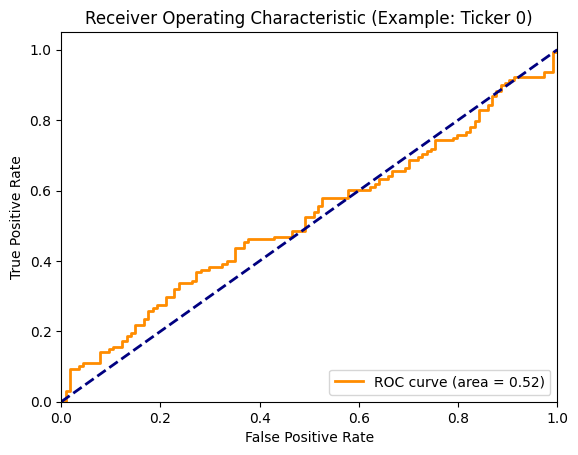


Basic Benchmark Model Evaluation Complete.


In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Import classification metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
# Import necessary Keras layers
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import Adam
# KerasTuner is no longer needed for this basic version
# from keras_tuner import RandomSearch
import matplotlib.pyplot as plt # For plotting ROC curve

# ... (Debugging prints and level detection remain the same) ...

# Drop 'OpenInt' if it exists
# ... (Code for dropping OpenInt remains the same) ...

# Feature engineering (Updated for log returns)
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        # Validate 'Close' exists
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            # Ensure the column is numeric and handle potential non-numeric entries
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Drop rows where Close price became NaN after coercion, if any
            df.dropna(subset=[col], inplace=True)
            if df[col].isnull().any(): # Check again after dropna, should not happen but safety check
                 print(f"Warning: 'Close' column for {ticker} contains NaNs after coercion. Skipping.")
                 continue
            if not np.issubdtype(df[col].dtype, np.number):
                 print(f"Warning: 'Close' column for {ticker} is not numeric. Skipping.")
                 continue
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue

        # Lag Features (remain the same)
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)

        # RSI (14-day) (remains the same)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10) # Added epsilon for stability
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))

        # EMA (10-day) (remains the same)
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()

        # --- Calculate Log Returns ---
        # Shift close price to align for calculation
        shifted_close = df[col].shift(1)
        # Calculate log returns, handle potential division by zero or log(0)
        # Replace 0s or negative prices with a small positive number before log
        safe_current_close = df[col].replace(0, 1e-10)
        safe_shifted_close = shifted_close.replace(0, 1e-10)
        df[(ticker, 'log_returns') if ticker_level == 0 else ('log_returns', ticker)] = np.log(safe_current_close / safe_shifted_close)
        # --- End Log Returns ---

        # Volatility (5-day of log returns)
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'log_returns') if ticker_level == 0 else ('log_returns', ticker)].rolling(window=5).std()

    # Drop the intermediate 'returns' column if it exists from previous runs
    if 'returns' in df.columns.levels[feature_level]:
         df = df.drop('returns', level=feature_level, axis=1)

    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    # Drop rows with NaNs introduced by feature engineering (lags, rolling windows)
    return df.dropna()

# Apply feature engineering
stocks_df_leveled = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# --- Time-based split (Correct: Done BEFORE windowing/scaling) ---
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)

train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]
print(f"Data split into Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- Rolling window data creation (Updated for Classification Target) ---
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1):
    """
    Creates rolling window features and a binary classification target (price up/down).
    Operates on a single pre-split DataFrame (train, val, or test).
    """
    X, y = [], []
    # Ensure tickers are correctly identified based on the level
    tickers = sorted([t for t in df.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
    num_tickers = len(tickers)
    # Update features list to include log_returns and remove simple 'returns'
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers ({tickers[:5]}...) with features: {features}")

    # Select feature columns dynamically based on detected levels
    feature_cols = []
    for feat in features:
        for tick in tickers:
             col = (tick, feat) if ticker_level == 0 else (feat, tick)
             if col in df.columns:
                 feature_cols.append(col)
             # else: # Optional: Warn if a feature is missing for a ticker
             #     print(f"  Debug: Feature {feat} for ticker {tick} not found in df columns.")

    # Ensure feature_cols are unique and maintain some order (though flatten later)
    feature_cols = sorted(list(set(feature_cols)))
    if not feature_cols:
         print("Error: No feature columns selected. Check feature names and DataFrame structure.")
         return np.array([]), np.array([]), 0

    print(f"Selected {len(feature_cols)} feature columns for windowing.")

    # Iterate through the DataFrame to create windows
    # Adjust range to avoid index errors near the end
    for i in range(window_size, len(df) - target_shift): # Adjusted end condition
        window_indices = df.index[i - window_size : i]
        target_index = df.index[i + target_shift -1] # Index for today's close
        next_day_index = df.index[i + target_shift]  # Index for next day's close

        # Extract feature window using .loc for safety with DateTimeIndex
        window_data = df.loc[window_indices, feature_cols]

        # Check if window data contains NaNs (shouldn't if dropna was effective)
        if window_data.isnull().values.any():
            # print(f"Skipping window ending at index {i} due to NaNs in features.")
            continue

        X.append(window_data.values.flatten())

        # --- Create Binary Target (Up/Down for each ticker) ---
        targets = []
        valid_target_count = 0
        for ticker in tickers:
            try:
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                today_close = df.loc[target_index, close_col]
                next_day_close = df.loc[next_day_index, close_col]

                # Check for NaN in target calculation
                if pd.isna(today_close) or pd.isna(next_day_close):
                     # print(f"Skipping target for ticker {ticker} at index {i} due to NaN close price.")
                     targets.append(np.nan) # Append NaN placeholder if target can't be calculated
                     continue

                # Target: 1 if next_day_close > today_close, 0 otherwise
                targets.append(1 if next_day_close > today_close else 0)
                valid_target_count += 1
            except KeyError as e:
                # print(f"Warning: Skipping target for ticker {ticker} at index {i} due to missing column {e}.")
                targets.append(np.nan) # Append NaN placeholder
                continue

        # Only append if we could calculate targets for all tickers for this window
        if valid_target_count == num_tickers:
            y.append(targets)
        else:
             # If targets are incomplete for this step, discard the corresponding X row
             X.pop()


    X = np.array(X)
    y = np.array(y)

    # Remove samples where any target is NaN (if placeholders were added and not handled above)
    if X.shape[0] > 0 and y.shape[0] > 0 and y.shape[1] == num_tickers:
        nan_target_rows = np.isnan(y).any(axis=1)
        X = X[~nan_target_rows]
        y = y[~nan_target_rows]
    elif X.shape[0] != y.shape[0]:
         print(f"Warning: Mismatch between X ({X.shape[0]}) and y ({y.shape[0]}) samples after NaN check. Resetting.")
         X, y = np.array([]), np.array([]) # Reset if shapes mismatch badly


    print(f"Created {X.shape[0]} windows with {y.shape[0]} targets (Shape: {y.shape})")
    # Return num_tickers identified from the input df
    return X, y, num_tickers

# --- Define Basic MLP Model Training ---
def train_basic_mlp(X_train_scaled, y_train, X_val_scaled, y_val, num_outputs):
    """Trains a simple MLP for binary classification."""
    input_shape = (X_train_scaled.shape[1],)
    model = Sequential([
        Input(shape=input_shape), # Use Input layer
        Dense(128, activation='relu'), # Simpler architecture
        Dense(64, activation='relu'),
        Dense(num_outputs, activation='sigmoid') # Sigmoid for binary classification per ticker
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), # Fixed learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print("Training basic MLP model...")
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_val_scaled, y_val),
                        epochs=50, # Fixed number of epochs
                        batch_size=64, # Adjusted batch size
                        verbose=1) # Show progress
    print("Training complete.")
    return model, history

# --- Main Execution ---
FIXED_WINDOW_SIZE = 10 # Use a fixed window size for the benchmark

# Create rolling windows separately for train, val, test sets
print("\nCreating training windows...")
X_train, y_train, num_tickers_train = create_rolling_window_data(
    train_df, window_size=FIXED_WINDOW_SIZE, ticker_level=ticker_level, feature_level=feature_level
)
print("\nCreating validation windows...")
X_val, y_val, num_tickers_val = create_rolling_window_data(
    val_df, window_size=FIXED_WINDOW_SIZE, ticker_level=ticker_level, feature_level=feature_level
)
print("\nCreating test windows...")
X_test, y_test, num_tickers_test = create_rolling_window_data(
    test_df, window_size=FIXED_WINDOW_SIZE, ticker_level=ticker_level, feature_level=feature_level
)

# --- Data Validation and Scaling (Crucial Step) ---
if not (num_tickers_train == num_tickers_val == num_tickers_test):
    raise ValueError("Inconsistent number of tickers found across data splits. Check data processing.")
num_tickers = num_tickers_train # Use the consistent number

if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data after windowing in one or more splits. Try a smaller window size or check data.")

# Scale features: Fit ONLY on training data
scaler = StandardScaler()
print("\nScaling data...")
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("Scaling complete.")

# --- Train the Basic Model ---
basic_model, history = train_basic_mlp(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)

# --- Evaluate the Basic Model ---
print("\nEvaluating basic model on test set...")
# Predict probabilities
y_pred_proba = basic_model.predict(X_test_scaled)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# --- Calculate Metrics ---
# Flatten arrays for overall metrics calculation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
y_pred_proba_flat = y_pred_proba.flatten()

# Accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# F1 Score (Weighted)
f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')
print(f"Overall Test F1 Score (Weighted): {f1:.4f}")

# ROC AUC Score (Weighted)
# Check if both classes are present in y_test_flat for ROC AUC
if len(np.unique(y_test_flat)) > 1:
    roc_auc = roc_auc_score(y_test_flat, y_pred_proba_flat, average='weighted')
    print(f"Overall Test ROC AUC Score (Weighted): {roc_auc:.4f}")

    # Optional: Plot ROC Curve for the first ticker as an example
    try:
        fpr, tpr, thresholds = roc_curve(y_test[:, 0], y_pred_proba[:, 0])
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') # Use overall AUC here
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (Example: Ticker 0)')
        plt.legend(loc="lower right")
        plt.show()
    except Exception as e:
        print(f"Could not plot ROC curve: {e}")

else:
    print("ROC AUC Score cannot be calculated because only one class is present in the test targets.")


# --- (Removed window size testing and hyperparameter tuning sections) ---

print("\nBasic Benchmark Model Evaluation Complete.")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from tensorflow.keras.models import Sequential
# ... other keras imports remain the same ...
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ... (Debugging prints and level detection remain the same) ...

# Drop 'OpenInt' if it exists
# ... (Code for dropping OpenInt remains the same) ...

# Feature engineering (Updated for log returns and classification)
def add_features(df, ticker_level=0, feature_level=1):
    tickers = [t for t in df.columns.levels[ticker_level] if t not in known_features]
    print(f"Processing tickers: {tickers[:10]}... (total: {len(tickers)})")
    for ticker in tickers:
        if ticker not in known_tickers:
            print(f"Warning: Skipping unknown ticker {ticker}")
            continue
        col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
        try:
            # Ensure the column is numeric and handle potential non-numeric entries
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Drop rows where Close price became NaN after coercion, if any
            df.dropna(subset=[col], inplace=True)
            if df[col].isnull().any(): # Check again after dropna
                 print(f"Warning: 'Close' column for {ticker} contains NaNs after coercion. Skipping.")
                 continue
            if not np.issubdtype(df[col].dtype, np.number):
                 print(f"Warning: 'Close' column for {ticker} is not numeric. Skipping.")
                 continue
        except KeyError:
            print(f"Warning: 'Close' not found for ticker {ticker}. Skipping.")
            continue

        # Lag Features (remain the same)
        df[(ticker, 'lag_1_close') if ticker_level == 0 else ('lag_1_close', ticker)] = df[col].shift(1)
        df[(ticker, 'lag_2_close') if ticker_level == 0 else ('lag_2_close', ticker)] = df[col].shift(2)

        # RSI (14-day) (remains the same)
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / (loss + 1e-10) # Added epsilon for stability
        df[(ticker, 'RSI') if ticker_level == 0 else ('RSI', ticker)] = 100 - (100 / (1 + rs))

        # EMA (10-day) (remains the same)
        df[(ticker, 'EMA_10') if ticker_level == 0 else ('EMA_10', ticker)] = df[col].ewm(span=10, adjust=False).mean()

        # --- Calculate Log Returns ---
        shifted_close = df[col].shift(1)
        # Replace 0s or negative prices with a small positive number before log
        safe_current_close = df[col].replace(0, 1e-10).clip(lower=1e-10)
        safe_shifted_close = shifted_close.replace(0, 1e-10).clip(lower=1e-10)
        df[(ticker, 'log_returns') if ticker_level == 0 else ('log_returns', ticker)] = np.log(safe_current_close / safe_shifted_close)
        # --- End Log Returns ---

        # Volatility (5-day of log returns)
        df[(ticker, 'volatility_5') if ticker_level == 0 else ('volatility_5', ticker)] = df[(ticker, 'log_returns') if ticker_level == 0 else ('log_returns', ticker)].rolling(window=5).std()

    # Drop the intermediate 'returns' column if it exists
    if 'returns' in df.columns.levels[feature_level]:
         df = df.drop('returns', level=feature_level, axis=1)

    # Impute missing values (e.g., from rolling calculations at the start) before dropping
    df = df.fillna(method='ffill').fillna(method='bfill')
    print("Feature engineering complete. Columns after:", df.columns.levels[feature_level].tolist())
    # Drop rows with NaNs introduced by feature engineering (lags, rolling windows)
    return df.dropna()

# Apply feature engineering
# ... (remains the same) ...

# Time-based split
# ... (remains the same) ...

# Correlation-Based Clustering
# ... (remains the same, including plotting Elbow/Silhouette) ...

# Rolling window data creation (Updated for Classification Target)
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    if len(df) < max_window_size + target_shift: # Adjusted condition slightly
        print(f"Warning: DataFrame too small (rows: {len(df)}) for window_size={window_size}, max_window_size={max_window_size}. Returning empty arrays.")
        return np.array([]), np.array([]), 0

    X, y = [], [] # Removed today_closes
    if tickers_to_use is None:
        tickers = sorted([t for t in df.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
    else:
        # Ensure tickers_to_use are valid and present in this df split
        valid_tickers_in_df = df.columns.levels[ticker_level]
        tickers = sorted([t for t in tickers_to_use if t in valid_tickers_in_df and t not in known_features])

    if not tickers:
        print("Warning: No valid tickers found for window creation.")
        return np.array([]), np.array([]), 0

    num_tickers = len(tickers)
    # Update features list
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers ({tickers[:5]}...) with features: {features}")

    if not isinstance(df.columns, pd.MultiIndex):
        print("Error: DataFrame must have a MultiIndex.")
        return np.array([]), np.array([]), num_tickers

    # Select feature columns dynamically
    feature_cols = []
    for feat in features:
        for tick in tickers:
             col = (tick, feat) if ticker_level == 0 else (feat, tick)
             if col in df.columns:
                 feature_cols.append(col)

    feature_cols = sorted(list(set(feature_cols)))
    if not feature_cols:
        print("Warning: No feature columns selected.")
        return np.array([]), np.array([]), num_tickers

    # Iterate through the DataFrame to create windows
    # Ensure indices exist before accessing
    valid_indices = df.index
    for i in range(max_window_size, len(df) - target_shift): # Adjusted end condition
        window_end_idx_loc = i
        window_start_idx_loc = i - window_size
        target_base_idx_loc = i # Today's index for comparison
        target_next_idx_loc = i + target_shift # Next day's index

        # Get actual index labels
        window_end_idx = valid_indices[window_end_idx_loc]
        window_start_idx = valid_indices[window_start_idx_loc]
        target_base_idx = valid_indices[target_base_idx_loc]
        target_next_idx = valid_indices[target_next_idx_loc]

        # Extract feature window using .loc
        window = df.loc[window_start_idx:window_end_idx, feature_cols].iloc[:-1] # Exclude the current day i from features

        if window.isnull().values.any() or window.shape[0] != window_size:
            # print(f"Skipping window ending {window_end_idx} due to NaNs or incorrect size ({window.shape[0]}).")
            continue

        X.append(window.values.flatten())

        # --- Create Binary Target (Up/Down for each ticker) ---
        targets = []
        valid_target_count = 0
        for ticker in tickers:
            try:
                close_col = (ticker, 'Close') if ticker_level == 0 else ('Close', ticker)
                # Use .loc with the actual index labels
                today_close = df.loc[target_base_idx, close_col]
                next_day_close = df.loc[target_next_idx, close_col]

                if pd.isna(today_close) or pd.isna(next_day_close):
                     targets.append(np.nan)
                     continue

                # Target: 1 if next_day_close > today_close, 0 otherwise
                targets.append(1 if next_day_close > today_close else 0)
                valid_target_count += 1
            except KeyError:
                targets.append(np.nan)
                continue
            except IndexError: # Handle cases where index might be out of bounds unexpectedly
                targets.append(np.nan)
                continue

        # Only append if we could calculate targets for all tickers
        if valid_target_count == num_tickers and not np.isnan(targets).any():
            y.append(targets)
        else:
            # Discard the corresponding X row if targets are incomplete/NaN
            X.pop()

    X = np.array(X)
    y = np.array(y)

    if X.shape[0] == 0 or y.shape[0] == 0:
        print("Warning: No valid windows created after processing.")
        return np.array([]), np.array([]), num_tickers
    if X.shape[0] != y.shape[0]:
         print(f"Warning: Mismatch between X ({X.shape[0]}) and y ({y.shape[0]}) samples. Resetting.")
         return np.array([]), np.array([]), num_tickers # Reset if shapes mismatch badly

    print(f"Created {X.shape[0]} windows with {y.shape[0]} targets (Shape: {y.shape}) for window_size={window_size}")
    return X, y, num_tickers # Return num_tickers based on input list

# Train model (Updated for Classification)
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(256, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(num_tickers, activation='sigmoid') # Sigmoid activation for binary classification per ticker
    ])
    optimizer = Adam(learning_rate=0.001)
    # Use binary_crossentropy loss and add accuracy metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    print(f"Training classification model with Dropout={dropout_rate}, L2 Reg={l2_reg}...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0 # Set to 1 to see epoch progress if needed
    )
    print(f"Finished training after {len(history.epoch)} epochs. Best val_loss: {min(history.history.get('val_loss', [np.inf])):.4f}, Best val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")
    return model

# Evaluate window sizes (Updated for Classification)
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=0, feature_level=1, max_window_size=15, tickers_to_use=None):
    print(f"Creating windows for train/val/test sets (window_size={window_size})...")
    # Update calls to create_rolling_window_data (no today_closes)
    X_train, y_train, num_tickers_train = create_rolling_window_data(
        train_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_val, y_val, num_tickers_val = create_rolling_window_data(
        val_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_test, y_test, num_tickers_test = create_rolling_window_data(
        test_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )

    # Check consistency of tickers identified in each split for this window size
    if not (num_tickers_train == num_tickers_val == num_tickers_test):
        print(f"Warning: Inconsistent number of tickers across splits for window {window_size} (train: {num_tickers_train}, val: {num_tickers_val}, test: {num_tickers_test}). Skipping.")
        # Return None for all probability arrays as well
        return None, None, None, None, None, None, None, None, None, None, None, None, None

    num_tickers = num_tickers_train # Use the consistent number
    if num_tickers == 0:
        print(f"Warning: No valid tickers for window_size={window_size}. Skipping.")
        return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Warning: Insufficient data after windowing for train/val/test split (window_size={window_size}). Skipping.")
        return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None

    # Ensure target shapes match num_tickers
    if y_train.shape[1] != num_tickers or y_val.shape[1] != num_tickers or y_test.shape[1] != num_tickers:
         print(f"Warning: Target shape mismatch for window {window_size}. y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}, num_tickers:{num_tickers}. Skipping.")
         return None, None, None, None, None, None, num_tickers, None, None, None, None, None, None


    scaler = StandardScaler()
    print(f"Scaling data (fitting on {X_train.shape[0]} training samples)...")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)

    # Get validation loss (the primary metric for optimization now)
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"Window={window_size}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Predict probabilities for validation and test sets
    y_val_pred_proba = model.predict(X_val_scaled, verbose=0)
    y_test_pred_proba = model.predict(X_test_scaled, verbose=0)

    # Return val_loss instead of MPE, and return probabilities instead of direct predictions
    # Removed today_closes_test from return values
    return val_loss, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred_proba, y_test_pred_proba, num_tickers # Adjusted return values

# Group-Specific Optimal Window Ensemble (Updated for Classification)
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)
print(f"window_range: {list(window_range)}, max(window_range): {max(window_range)}")
all_group_predictions_proba = {} # Store probabilities
all_group_y_test = {}
# all_group_today_closes = {} # No longer needed for classification metrics
group_final_accuracy = {} # Store accuracy per group
group_final_f1 = {}       # Store F1 per group
group_final_roc_auc = {}  # Store ROC AUC per group
group_models_dict = {}
all_tickers_ordered = sorted([t for t in stocks_df_leveled.columns.levels[ticker_level] if str(t).lower() not in known_features and t in known_tickers])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}
num_total_tickers = len(all_tickers_ordered)

# Define the features used by the model (consistent with create_rolling_window_data and add_features)
# Include 'Close' as it's needed for target generation, even if not a direct input feature later
model_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']


for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers: {group_tickers})...")

    # --- Dynamically define columns for THIS group based on CURRENT features ---
    group_cols = []
    for feat in model_features:
        for tick in group_tickers:
            # Construct the MultiIndex tuple based on detected levels
            col = (tick, feat) if ticker_level == 0 else (feat, tick)
            # IMPORTANT: Check if the column actually exists in the *original* dataframes
            # This prevents KeyErrors if a feature couldn't be calculated for a specific ticker/split
            if col in train_df.columns and col in val_df.columns and col in test_df.columns:
                group_cols.append(col)
            # else:
            #     print(f"Debug: Column {col} not found in one of the dataframes for group {group_id}") # Optional debug print

    # Ensure columns are unique and sorted (optional but good practice)
    group_cols = sorted(list(set(group_cols)))

    if not group_cols:
        print(f"Warning: No valid columns found for group {group_id} after checking existence. Skipping group.")
        continue
    # --- End dynamic column definition ---

    # Filter dataframes using the dynamically generated columns for this group
    try:
        train_df_group = train_df[group_cols]
        val_df_group = val_df[group_cols]
        test_df_group = test_df[group_cols]
    except KeyError as e:
         # This catch might be less likely now, but kept for safety
         print(f"Error selecting columns for group {group_id} even after checks: {e}. Skipping group.")
         continue

    group_models = {}
    group_scalers = {}
    group_predictions_val_proba = {} # Store validation probabilities
    group_predictions_test_proba = {} # Store test probabilities
    group_y_val_actual = None
    group_y_test_actual = None
    # group_today_closes_test_data = None # Removed

    for window_size in window_range:
        print(f"Evaluating Group {group_id}, Window Size {window_size}...")
        # Update call to evaluate_window_size and expected return values
        val_loss, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred_proba, y_test_pred_proba, num_tickers = evaluate_window_size(
            train_df_group, val_df_group, test_df_group, window_size, ticker_level=ticker_level, feature_level=feature_level,
            max_window_size=max(window_range), tickers_to_use=group_tickers
        )

        if model is None: # Check if evaluation failed
            print(f"Skipping window size {window_size} for Group {group_id} due to evaluation issues.")
            continue
        if y_val_pred_proba is None or y_test_pred_proba is None:
             print(f"Skipping window size {window_size} for Group {group_id} due to missing predictions.")
             continue


        group_models[window_size] = model
        group_scalers[window_size] = scaler
        group_predictions_val_proba[window_size] = y_val_pred_proba
        group_predictions_test_proba[window_size] = y_test_pred_proba

        # Store actual targets (make sure they are consistent)
        if group_y_val_actual is None and y_val is not None:
            group_y_val_actual = y_val
        elif y_val is not None and group_y_val_actual.shape != y_val.shape:
             print(f"Inconsistent y_val shape for window {window_size}. Expected {group_y_val_actual.shape}, got {y_val.shape}. Skipping window.")
             del group_models[window_size], group_scalers[window_size], group_predictions_val_proba[window_size], group_predictions_test_proba[window_size]
             continue

        if group_y_test_actual is None and y_test is not None:
            group_y_test_actual = y_test
        elif y_test is not None and group_y_test_actual.shape != y_test.shape:
             print(f"Inconsistent y_test shape for window {window_size}. Expected {group_y_test_actual.shape}, got {y_test.shape}. Skipping window.")
             # Clean up entries for this inconsistent window size
             if window_size in group_models: del group_models[window_size]
             if window_size in group_scalers: del group_scalers[window_size]
             if window_size in group_predictions_val_proba: del group_predictions_val_proba[window_size]
             if window_size in group_predictions_test_proba: del group_predictions_test_proba[window_size]
             continue
        # group_today_closes_test_data = None # Removed

    # --- Ensemble Weight Optimization (using Log Loss) ---
    if not group_models:
        print(f"Warning: No valid models trained for Group {group_id}. Skipping ensemble.")
        continue
    if group_y_val_actual is None or group_y_test_actual is None:
        print(f"Warning: Actual target data missing for Group {group_id}. Skipping ensemble.")
        continue

    print(f"\nOptimizing ensemble weights for Group {group_id} using {len(group_models)} models based on validation log loss...")
    valid_window_sizes = sorted(group_predictions_val_proba.keys())
    val_preds_proba_list = [group_predictions_val_proba[ws] for ws in valid_window_sizes]

    if not val_preds_proba_list:
        print(f"Error: No validation probability predictions available for Group {group_id}. Skipping.")
        continue
    first_shape = val_preds_proba_list[0].shape
    if group_y_val_actual.shape != first_shape:
        print(f"Error: Shape mismatch between actual validation targets {group_y_val_actual.shape} and probabilities {first_shape} in Group {group_id}. Skipping.")
        continue
    if not all(p.shape == first_shape for p in val_preds_proba_list):
        print(f"Error: Validation probabilities have inconsistent shapes in Group {group_id}. Skipping weight optimization.")
        continue

    val_preds_proba = np.stack(val_preds_proba_list, axis=-1) # Shape: (n_samples, n_tickers, n_models)
    y_val_true = group_y_val_actual # Shape: (n_samples, n_tickers)

    # Define loss function based on log loss
    def loss_function_logloss(weights):
        # Ensure weights sum to 1 and are non-negative implicitly by optimization bounds
        # Add small epsilon to weights before normalization if needed, but SLSQP handles bounds
        # weights = weights / np.sum(weights) # Normalization handled by constraint

        # Calculate weighted average of probabilities
        weighted_pred_proba = np.sum(val_preds_proba * weights[None, None, :], axis=-1)

        # Clip probabilities for log loss stability
        epsilon = 1e-15
        weighted_pred_proba = np.clip(weighted_pred_proba, epsilon, 1 - epsilon)

        # Calculate log loss
        loss = log_loss(y_val_true.flatten(), weighted_pred_proba.flatten(), labels=[0, 1])
        return loss

    num_models_in_ensemble = len(valid_window_sizes)
    initial_weights = np.ones(num_models_in_ensemble) / num_models_in_ensemble
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(num_models_in_ensemble)]

    # Use minimize with SLSQP for constrained optimization
    result = minimize(loss_function_logloss, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False})

    if result.success:
        optimal_weights = result.x
        # Ensure weights are non-negative and sum to 1 after optimization
        optimal_weights = np.maximum(0, optimal_weights)
        optimal_weights /= np.sum(optimal_weights)
        print(f"Optimal weights for Group {group_id} (based on val log loss):")
        for ws, w in zip(valid_window_sizes, optimal_weights):
            print(f"  Window {ws}: {w:.4f}")
    else:
        print(f"Warning: Weight optimization failed for Group {group_id} (Message: {result.message}). Using equal weights.")
        optimal_weights = initial_weights

    # --- Create Ensemble Prediction (Probabilities) ---
    print(f"Creating ensemble probability prediction for Group {group_id} test set...")
    test_preds_proba_list = [group_predictions_test_proba[ws] for ws in valid_window_sizes]

    if not test_preds_proba_list:
        print(f"Error: No test probability predictions available for Group {group_id}. Skipping.")
        continue
    first_test_shape = test_preds_proba_list[0].shape
    if group_y_test_actual.shape != first_test_shape:
        print(f"Error: Shape mismatch between actual test targets {group_y_test_actual.shape} and probabilities {first_test_shape} in Group {group_id}. Skipping.")
        continue
    if not all(p.shape == first_test_shape for p in test_preds_proba_list):
        print(f"Error: Test probabilities have inconsistent shapes in Group {group_id}. Skipping ensemble prediction.")
        continue

    test_preds_proba = np.stack(test_preds_proba_list, axis=-1)
    group_ensemble_pred_proba = np.sum(test_preds_proba * optimal_weights[None, None, :], axis=-1)

    # Store probabilities and actuals
    all_group_predictions_proba[group_id] = group_ensemble_pred_proba
    all_group_y_test[group_id] = group_y_test_actual
    # Removed today_closes storage

    group_models_dict[group_id] = group_models # Keep storing models if needed later

    # --- Calculate and store group-level classification metrics ---
    group_pred_binary = (group_ensemble_pred_proba > 0.5).astype(int)
    group_y_test_flat = group_y_test_actual.flatten()
    group_pred_binary_flat = group_pred_binary.flatten()
    group_pred_proba_flat = group_ensemble_pred_proba.flatten()

    group_accuracy = accuracy_score(group_y_test_flat, group_pred_binary_flat)
    group_f1 = f1_score(group_y_test_flat, group_pred_binary_flat, average='weighted')
    group_roc_auc = roc_auc_score(group_y_test_flat, group_pred_proba_flat, average='weighted') if len(np.unique(group_y_test_flat)) > 1 else np.nan

    group_final_accuracy[group_id] = group_accuracy
    group_final_f1[group_id] = group_f1
    group_final_roc_auc[group_id] = group_roc_auc

    print(f"  Group {group_id} Ensemble: Test Accuracy = {group_accuracy:.4f}, F1 = {group_f1:.4f}, ROC AUC = {'N/A' if np.isnan(group_roc_auc) else f'{group_roc_auc:.4f}'}")


# Combine Group Predictions (Probabilities)
if not all_group_predictions_proba:
    print("\nError: No group probability predictions were generated. Cannot combine or evaluate final ensemble.")
else:
    try:
        # Find the first group with predictions to determine the number of test samples
        first_valid_group_id = next(iter(all_group_predictions_proba))
        num_test_samples = all_group_predictions_proba[first_valid_group_id].shape[0]
    except StopIteration:
        print("\nError: Could not determine number of test samples. No valid group predictions found.")
        num_test_samples = 0

    if num_test_samples > 0:
        # Initialize arrays to store combined results (probabilities and actuals)
        final_ensemble_pred_proba = np.full((num_test_samples, num_total_tickers), np.nan) # Store probabilities
        final_y_test = np.full((num_test_samples, num_total_tickers), np.nan) # Store actual binary targets
        processed_tickers_count = 0

        for group_id, group_tickers in groups.items():
            if group_id not in all_group_predictions_proba:
                print(f"Warning: Skipping group {group_id} in final combination as it has no probability predictions.")
                continue
            if group_id not in all_group_y_test:
                print(f"Warning: Skipping group {group_id} in final combination as it has no actual test data.")
                continue

            # Check for consistent number of samples
            if all_group_predictions_proba[group_id].shape[0] != num_test_samples:
                print(f"Warning: Skipping group {group_id} due to inconsistent number of test samples ({all_group_predictions_proba[group_id].shape[0]} vs {num_test_samples}).")
                continue
            if all_group_y_test[group_id].shape[0] != num_test_samples:
                 print(f"Warning: Skipping group {group_id} due to inconsistent number of actual test samples ({all_group_y_test[group_id].shape[0]} vs {num_test_samples}).")
                 continue

            group_pred_proba = all_group_predictions_proba[group_id] # Shape: (n_samples, n_group_tickers)
            group_y = all_group_y_test[group_id] # Shape: (n_samples, n_group_tickers)

            # Check if number of tickers match between predictions and actuals for the group
            if group_pred_proba.shape[1] != len(group_tickers) or group_y.shape[1] != len(group_tickers):
                print(f"Warning: Ticker count mismatch within group {group_id}. Preds: {group_pred_proba.shape[1]}, Actuals: {group_y.shape[1]}, Expected: {len(group_tickers)}. Skipping group.")
                continue

            for i, ticker in enumerate(group_tickers):
                if ticker not in ticker_to_index_map:
                    print(f"Warning: Ticker {ticker} from group {group_id} not found in overall ticker map. Skipping.")
                    continue
                original_idx = ticker_to_index_map[ticker] # Index in the final combined array

                # Assign probabilities and actuals to the final arrays
                final_ensemble_pred_proba[:, original_idx] = group_pred_proba[:, i]
                final_y_test[:, original_idx] = group_y[:, i]
                # Increment count only if assignment is successful (ticker exists in map)
                # Note: We don't increment processed_tickers_count here, but rather check non-NaN columns later

        # --- Final Ensemble Evaluation (Classification Metrics) ---
        print(f"\n--- Final Ensemble Evaluation ({num_total_tickers} total tickers targeted) ---")

        # Flatten arrays, removing NaNs where *either* prediction or actual is NaN
        valid_mask = ~np.isnan(final_ensemble_pred_proba) & ~np.isnan(final_y_test)
        if not np.any(valid_mask):
             print("Error: No valid (non-NaN) data points found after combining group predictions. Cannot evaluate.")
        else:
            final_y_test_flat = final_y_test[valid_mask]
            final_pred_proba_flat = final_ensemble_pred_proba[valid_mask]
            final_pred_binary_flat = (final_pred_proba_flat > 0.5).astype(int) # Binary predictions from probabilities

            # Calculate overall metrics
            final_accuracy = accuracy_score(final_y_test_flat, final_pred_binary_flat)
            final_f1 = f1_score(final_y_test_flat, final_pred_binary_flat, average='weighted')

            print(f"Group-Based Ensemble Overall Test Accuracy: {final_accuracy:.4f}")
            print(f"Group-Based Ensemble Overall Test F1 Score (Weighted): {final_f1:.4f}")

            # Calculate ROC AUC only if both classes are present
            if len(np.unique(final_y_test_flat)) > 1:
                final_roc_auc = roc_auc_score(final_y_test_flat, final_pred_proba_flat, average='weighted')
                print(f"Group-Based Ensemble Overall Test ROC AUC Score (Weighted): {final_roc_auc:.4f}")

                # --- Plot Micro-Averaged ROC Curve ---
                try:
                    fpr, tpr, _ = roc_curve(final_y_test_flat, final_pred_proba_flat)
                    roc_auc_value = auc(fpr, tpr)

                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro-average ROC curve (area = {roc_auc_value:.4f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (Micro-Average over all tickers/days)')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.savefig('final_ensemble_roc_curve.png')
                    print("Saved final ensemble ROC curve plot to 'final_ensemble_roc_curve.png'")
                    plt.close() # Close the plot to prevent display in non-interactive environments
                except Exception as e:
                    print(f"Could not plot final ROC curve: {e}")
            else:
                print("Final ROC AUC Score cannot be calculated because only one class is present in the combined test targets.")
                final_roc_auc = np.nan # Set to NaN if not calculable
    else:
        print("\nSkipping final ensemble evaluation as no test samples were generated.")

# Check for unprocessed tickers (remains the same)
processed_tickers = set()
for group_tickers in groups.values():
    processed_tickers.update(group_tickers)
unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"\nWarning: Tickers not processed in any group: {unprocessed_tickers}")

print("\n--- Script Execution Finished ---")


--- Group-Specific Optimal Window Ensemble ---
window_range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], max(window_range): 15

Processing Group 0 (4 tickers: ['ABT', 'JNJ', 'SYK', 'TMO'])...
Evaluating Group 0, Window Size 1...
Creating windows for train/val/test sets (window_size=1)...
Creating rolling windows for 4 tickers (['ABT', 'JNJ', 'SYK', 'TMO']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
Created 740 windows with 740 targets (Shape: (740, 4)) for window_size=1
Creating rolling windows for 4 tickers (['ABT', 'JNJ', 'SYK', 'TMO']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
Created 236 windows with 236 targets (Shape: (236, 4)) for window_size=1
Creating rolling windows for 4 tickers (['ABT', 'JNJ', 'SYK', 'TMO']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RS

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__) # Also print TF version
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available:  1


TensorFlow version: 2.16.2
Num GPUs Available:  1
Loading combined data from: /Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/filtered_stocks_combined.csv
Successfully loaded data for 50 tickers.
Columns in loaded data: ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'ticker']
Pivoting data using columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
Set column level names to 'Feature' and 'Ticker'.
Data shape after pivot: (1510, 300)
Index name (Date): Date
Column Level 0 (Features): Feature
Column Level 1 (Tickers): Ticker
Dropping 'OpenInt' column.
Adding features for 50 tickers: ['AAPL', 'ABT', 'ADBE', 'AMD', 'AMGN']...
Imputing missing values introduced by feature engineering...
Dropped 0 rows with NaNs after feature engineering and imputation.
Feature engineering complete. Final columns: ['Close', 'EMA_10', 'High', 'Low', 'Open', 'OpenInt', 'RSI', 'Volume', 'lag_1_close', 'lag_2_close', 'log_returns', 'volatility_5']

Data split into Train: 906, Validati

/var/folders/7r/9fzqnfrn3gb83dkk5f562fbh0000gp/T/ipykernel_55752/2444615980.py:158: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy = df_copy.fillna(method='ffill').fillna(method='bfill')


Saved Elbow and Silhouette plots to '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/Output/fft_clustering_elbow_silhouette.png'


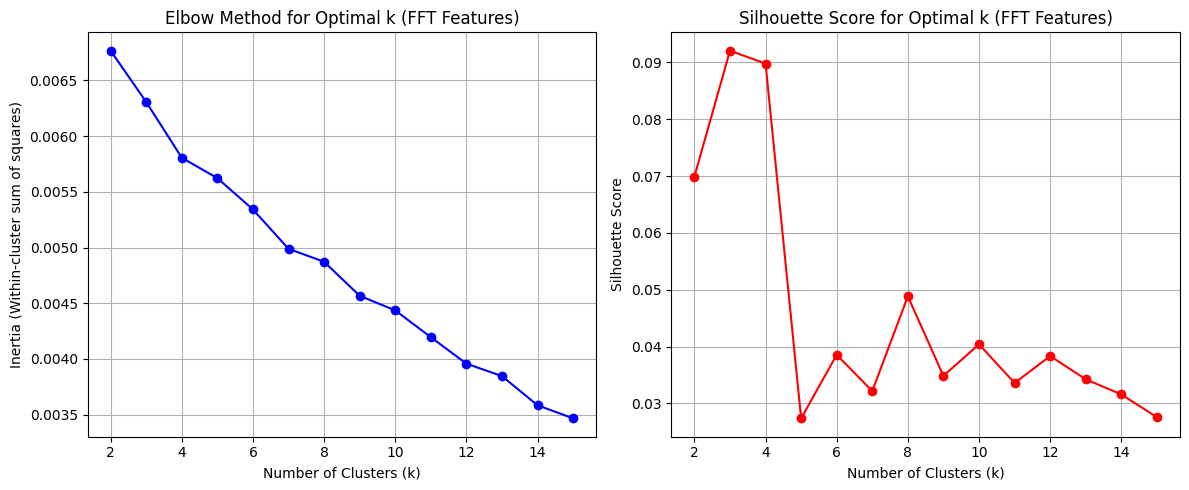

Recommended k based on max Silhouette Score: 3

Performing final K-Means clustering with k=3...
Created 3 groups based on FFT clustering:
  Group 0: 11 tickers - ['ABT', 'CVX', 'HD', 'JNJ', 'LLY']...
  Group 1: 1 tickers - ['AAPL']...
  Group 2: 38 tickers - ['ADBE', 'AMD', 'AMGN', 'AMZN', 'AXP']...
Saved Average PSD per Cluster plot to '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/Output/fft_average_psd_per_cluster.png'


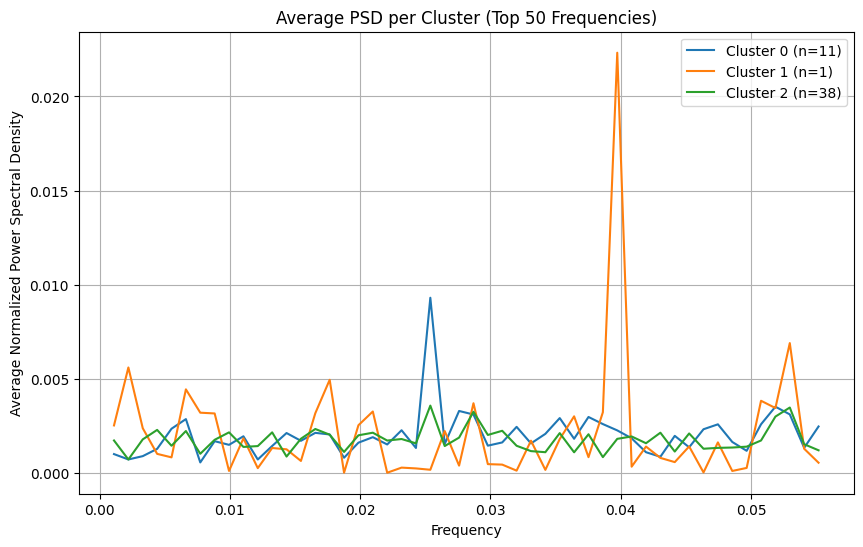


--- Group-Specific Optimal Window Ensemble ---
Evaluating window sizes in range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Total number of unique tickers being processed: 50

Processing Group 0 (11 tickers: ['ABT', 'CVX', 'HD', 'JNJ', 'LLY', 'MRK', 'PFE', 'PG', 'UNH', 'WMT']...).
Filtered data for group 0. Train shape: (906, 121), Val shape: (302, 121), Test shape: (302, 121)
  Evaluating Group 0, Window Size 1...
Creating windows for train/val/test sets (window_size=1)...
Creating rolling windows for 11 tickers (['ABT', 'CVX', 'HD', 'JNJ', 'LLY']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
Selected 110 feature columns for windowing.
Created 904 windows with 904 targets (Shape: (904, 11)) for window_size=1
Creating rolling windows for 11 tickers (['ABT', 'CVX', 'HD', 'JNJ', 'LLY']...) with features: ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_retur

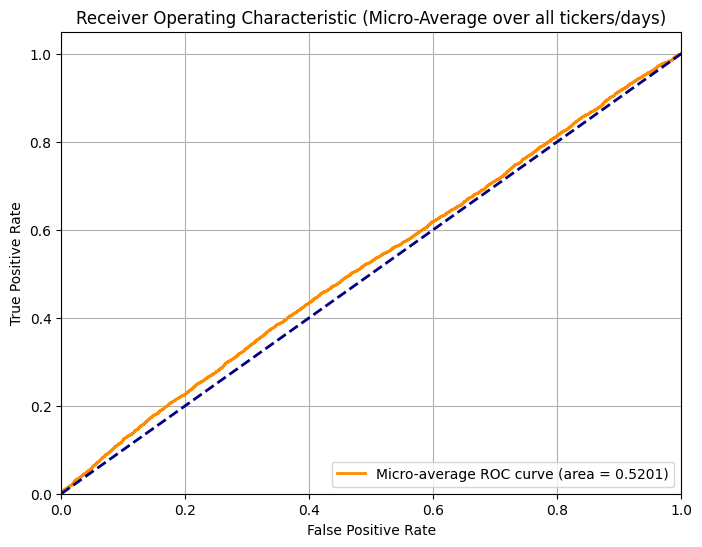


--- Script Execution Finished ---


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from scipy.fft import fft, fftfreq
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# --- GPU Check (Apple Silicon) ---
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- Configuration & Data Loading ---
combined_data_path = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/filtered_stocks_combined.csv'
OUTPUT_DIR = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/Output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Loading combined data from: {combined_data_path}")
try:
    # Specify dtype for 'ticker' to avoid mixed type warnings if some are purely numeric
    stocks_df = pd.read_csv(combined_data_path, parse_dates=['Date'], dtype={'ticker': str})
    # Drop the extra 'index' column if it exists and isn't needed
    if 'index' in stocks_df.columns:
        stocks_df = stocks_df.drop(columns=['index'])
    # Set 'Date' as the index
    stocks_df = stocks_df.set_index('Date')
    stocks_df = stocks_df.sort_index()
    # Get the list of tickers directly from the loaded data
    known_tickers = set(stocks_df['ticker'].unique())
    print(f"Successfully loaded data for {len(known_tickers)} tickers.")
    print(f"Columns in loaded data: {stocks_df.columns.tolist()}")

except FileNotFoundError:
    raise FileNotFoundError(f"Error: The file was not found at {combined_data_path}")
except Exception as e:
    raise ValueError(f"Error loading or processing {combined_data_path}: {e}")

if stocks_df.empty:
    raise ValueError("Loaded DataFrame is empty. Check the CSV file content.")

# --- Data Preprocessing & Initial Setup ---
# Pivot the table based on columns available in the CSV
available_value_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
pivot_values = [col for col in available_value_cols if col in stocks_df.columns]
if not pivot_values:
    raise ValueError("Could not find standard OHLCV columns in the loaded data for pivoting.")

print(f"Pivoting data using columns: {pivot_values}")
if 'ticker' not in stocks_df.columns:
    raise ValueError("The 'ticker' column is missing from the loaded DataFrame, cannot pivot.")

stocks_df_leveled = stocks_df.pivot_table(index='Date', columns='ticker', values=pivot_values)

# Identify levels
date_level = stocks_df_leveled.index.name
feature_level = 0  # Corresponds to 'Open', 'High', etc.
ticker_level = 1   # Corresponds to ticker symbols

# Set names explicitly if they are None after pivot
if stocks_df_leveled.columns.names[0] is None or stocks_df_leveled.columns.names[1] is None:
    stocks_df_leveled.columns.names = ['Feature', 'Ticker']
    print(f"Set column level names to 'Feature' and 'Ticker'.")
else:
    # Ensure correct level order (Features first, then Tickers)
    if stocks_df_leveled.columns.names[ticker_level] == 'Feature' and stocks_df_leveled.columns.names[feature_level] == 'Ticker':
        print("Swapping column levels to Feature/Ticker...")
        stocks_df_leveled.columns = stocks_df_leveled.columns.swaplevel(0, 1)
        feature_level, ticker_level = 0, 1
        print(f"New Column Level 0 (Features): {stocks_df_leveled.columns.names[0]}")
        print(f"New Column Level 1 (Tickers): {stocks_df_leveled.columns.names[1]}")
    elif stocks_df_leveled.columns.names[feature_level] == 'Feature' and stocks_df_leveled.columns.names[ticker_level] == 'Ticker':
        print("Column levels already in Feature/Ticker order.")
    else:
        print(f"Setting column level names to 'Feature' and 'Ticker'. Original: {stocks_df_leveled.columns.names}")
        stocks_df_leveled.columns.names = ['Feature', 'Ticker']
        feature_level, ticker_level = 0, 1

print(f"Data shape after pivot: {stocks_df_leveled.shape}")
print(f"Index name (Date): {date_level}")
print(f"Column Level 0 (Features): {stocks_df_leveled.columns.names[feature_level]}")
print(f"Column Level 1 (Tickers): {stocks_df_leveled.columns.names[ticker_level]}")

stocks_df_leveled = stocks_df_leveled.sort_index(axis=1)

# Define known features based on CSV and engineered ones
known_features_base = {'Open', 'High', 'Low', 'Close', 'Volume'}  # From CSV (excluding OpenInt)
known_features_eng = {'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5'}  # To be engineered
known_features = known_features_base.union(known_features_eng)

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    print("Dropping 'OpenInt' column.")
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    known_features_base.discard('OpenInt')

# --- Feature Engineering ---
def add_features(df, ticker_level=1, feature_level=0):
    tickers = sorted([t for t in df.columns.levels[ticker_level] if t in known_tickers])
    print(f"Adding features for {len(tickers)} tickers: {tickers[:5]}...")

    df_copy = df.copy()
    for ticker in tickers:
        close_col = ('Close', ticker)
        open_col = ('Open', ticker)
        high_col = ('High', ticker)
        low_col = ('Low', ticker)
        vol_col = ('Volume', ticker)

        if close_col not in df_copy.columns:
            print(f"Warning: 'Close' column not found for ticker {ticker}. Skipping feature calculation.")
            continue

        try:
            for col_tpl in [open_col, high_col, low_col, close_col, vol_col]:
                if col_tpl in df_copy.columns:
                    df_copy[col_tpl] = pd.to_numeric(df_copy[col_tpl], errors='coerce')

            df_copy.dropna(subset=[close_col], inplace=True)
            if df_copy[close_col].isnull().any():
                print(f"Warning: 'Close' column for {ticker} still contains NaNs after dropna. Skipping.")
                continue
            if not np.issubdtype(df_copy[close_col].dtype, np.number):
                print(f"Warning: 'Close' column for {ticker} is not numeric after coercion. Skipping.")
                continue

            df_copy[('lag_1_close', ticker)] = df_copy[close_col].shift(1)
            df_copy[('lag_2_close', ticker)] = df_copy[close_col].shift(2)
            delta = df_copy[close_col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)
            df_copy[('RSI', ticker)] = 100 - (100 / (1 + rs))
            df_copy[('EMA_10', ticker)] = df_copy[close_col].ewm(span=10, adjust=False).mean()
            shifted_close = df_copy[close_col].shift(1)
            safe_current_close = df_copy[close_col].replace(0, 1e-10).clip(lower=1e-10)
            safe_shifted_close = shifted_close.replace(0, 1e-10).clip(lower=1e-10)
            df_copy[('log_returns', ticker)] = np.log(safe_current_close / safe_shifted_close)
            log_ret_col = ('log_returns', ticker)
            if log_ret_col in df_copy.columns:
                df_copy[('volatility_5', ticker)] = df_copy[log_ret_col].rolling(window=5).std()

        except Exception as e:
            print(f"Error calculating features for {ticker}: {e}")
            continue

    print("Imputing missing values introduced by feature engineering...")
    df_copy = df_copy.fillna(method='ffill').fillna(method='bfill')
    initial_rows = len(df_copy)
    df_copy = df_copy.dropna()
    print(f"Dropped {initial_rows - len(df_copy)} rows with NaNs after feature engineering and imputation.")
    df_copy = df_copy.sort_index(axis=1)
    print("Feature engineering complete. Final columns:", df_copy.columns.levels[feature_level].tolist())
    return df_copy

# Apply feature engineering
stocks_df_featured = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# --- Time-based split ---
total_len = len(stocks_df_featured)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)
train_df = stocks_df_featured.iloc[:train_end]
val_df = stocks_df_featured.iloc[train_end:val_end]
test_df = stocks_df_featured.iloc[val_end:]
print(f"\nData split into Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- Fourier Transform (FFT) Based Clustering ---
print("\n--- Fourier Transform (FFT) Based Clustering ---")
log_return_cols = [col for col in train_df.columns if col[0] == 'log_returns']
if not log_return_cols:
    raise ValueError("No 'log_returns' columns found in train_df. Ensure feature engineering ran correctly.")

log_returns_train = train_df[log_return_cols].copy()
log_returns_train.columns = log_returns_train.columns.droplevel(0)
log_returns_train = log_returns_train.fillna(0)
print(f"Using log returns from training data (shape: {log_returns_train.shape}) for FFT clustering.")

N_freq_components = 50
psd_features = {}
num_samples = len(log_returns_train)
fft_freq = fftfreq(num_samples)[1:num_samples//2]

if N_freq_components >= len(fft_freq):
    print(f"Warning: N_freq_components ({N_freq_components}) >= available positive frequencies ({len(fft_freq)}). Using all available frequencies.")
    N_freq_components = len(fft_freq)

print(f"Calculating PSD using first {N_freq_components} positive frequency components...")
for ticker in log_returns_train.columns:
    returns = log_returns_train[ticker].values
    if np.all(returns == 0):
        print(f"Skipping ticker {ticker} for FFT due to all zero returns.")
        continue
    fft_vals = fft(returns)
    psd = np.abs(fft_vals[1:num_samples//2])**2
    if len(psd) == 0:
        print(f"Skipping ticker {ticker} due to empty PSD (likely insufficient data points: {num_samples}).")
        continue
    psd_normalized = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_features[ticker] = psd_normalized[:N_freq_components]

if not psd_features:
    raise ValueError("No PSD features could be calculated. Check log returns data and N_freq_components.")

psd_df = pd.DataFrame(psd_features).T
max_len = N_freq_components
psd_df = psd_df.apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len], axis=1, result_type='expand')
psd_df.columns = [f'freq_{i+1}' for i in range(max_len)]
psd_df = psd_df.fillna(0)
tickers_for_clustering = psd_df.index.tolist()
print(f"Created PSD feature matrix for {len(tickers_for_clustering)} tickers with {psd_df.shape[1]} features.")

k_range = range(2, 16)
inertia = []
silhouette_scores = []

print("Determining optimal number of clusters using Elbow and Silhouette methods...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(psd_df)
    inertia.append(kmeans.inertia_)
    if k > 1:
        score = silhouette_score(psd_df, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"  k={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")
    else:
        silhouette_scores.append(np.nan)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k (FFT Features)')
plt.grid(True)

plt.subplot(1, 2, 2)
k_range_plot = list(k_range)
plt.plot(k_range_plot, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (FFT Features)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png'))
print(f"Saved Elbow and Silhouette plots to '{os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png')}'")
plt.show()

optimal_k_silhouette = k_range_plot[np.nanargmax(silhouette_scores)] if not np.all(np.isnan(silhouette_scores)) else 5
print(f"Recommended k based on max Silhouette Score: {optimal_k_silhouette}")
n_clusters = optimal_k_silhouette

print(f"\nPerforming final K-Means clustering with k={n_clusters}...")
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(psd_df)

groups = {i: [] for i in range(n_clusters)}
for ticker, label in zip(tickers_for_clustering, cluster_labels):
    groups[label].append(ticker)

print(f"Created {n_clusters} groups based on FFT clustering:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {len(tickers_in_group)} tickers - {tickers_in_group[:5]}...")

plt.figure(figsize=(10, 6))
freq_axis = fft_freq[:N_freq_components]
for group_id, tickers_in_group in groups.items():
    if tickers_in_group:
        group_psd_features = psd_df.loc[tickers_in_group].values
        avg_psd = np.mean(group_psd_features, axis=0)
        plt.plot(freq_axis, avg_psd, label=f'Cluster {group_id} (n={len(tickers_in_group)})')
plt.xlabel('Frequency')
plt.ylabel('Average Normalized Power Spectral Density')
plt.title(f'Average PSD per Cluster (Top {N_freq_components} Frequencies)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'fft_average_psd_per_cluster.png'))
print(f"Saved Average PSD per Cluster plot to '{os.path.join(OUTPUT_DIR, 'fft_average_psd_per_cluster.png')}'")
plt.show()

# --- Rolling window data creation (Updated for Classification Target) ---
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    if len(df) < max(window_size, 1) + target_shift:
        print(f"Warning: DataFrame too small (rows: {len(df)}) for window_size={window_size}, target_shift={target_shift}. Returning empty arrays.")
        return np.array([]), np.array([]), 0

    X, y = [], []
    if tickers_to_use is None:
        valid_tickers_in_df = sorted([t for t in df.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
        tickers = valid_tickers_in_df
    else:
        valid_tickers_in_df = df.columns.levels[ticker_level]
        tickers = sorted([t for t in tickers_to_use if t in valid_tickers_in_df and t not in known_features])

    if not tickers:
        print("Warning: No valid tickers found for window creation in this DataFrame split.")
        return np.array([]), np.array([]), 0

    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers ({tickers[:5]}...) with features: {features}")

    if not isinstance(df.columns, pd.MultiIndex):
        print("Error: DataFrame must have a MultiIndex.")
        return np.array([]), np.array([]), num_tickers

    feature_cols = []
    missing_feature_warning = False
    for feat in features:
        for tick in tickers:
            col = (feat, tick)
            if col in df.columns:
                feature_cols.append(col)
            else:
                missing_feature_warning = True

    if missing_feature_warning:
        print("Warning: Some feature/ticker combinations were not found in the input DataFrame.")

    feature_cols = sorted(list(set(feature_cols)))
    if not feature_cols:
        print("Warning: No feature columns selected after checking availability.")
        return np.array([]), np.array([]), num_tickers

    print(f"Selected {len(feature_cols)} feature columns for windowing.")

    valid_indices = df.index
    start_offset = max(window_size, 1)
    for i in range(start_offset, len(df) - target_shift):
        window_end_idx_loc = i
        window_start_idx_loc = i - window_size
        target_base_idx_loc = i
        target_next_idx_loc = i + target_shift

        try:
            window_start_idx = valid_indices[window_start_idx_loc]
            window_end_idx = valid_indices[window_end_idx_loc]
            target_base_idx = valid_indices[target_base_idx_loc]
            target_next_idx = valid_indices[target_next_idx_loc]
        except IndexError:
            continue

        window = df.loc[window_start_idx : window_end_idx, feature_cols].iloc[:-1]
        if window.shape[0] != window_size:
            continue
        if window.isnull().values.any():
            continue

        X.append(window.values.flatten())
        targets = []
        valid_target_count = 0
        for ticker in tickers:
            try:
                close_col = ('Close', ticker)
                today_close = df.loc[target_base_idx, close_col]
                next_day_close = df.loc[target_next_idx, close_col]
                if pd.isna(today_close) or pd.isna(next_day_close):
                    targets.append(np.nan)
                    continue
                targets.append(1 if next_day_close > today_close else 0)
                valid_target_count += 1
            except KeyError:
                targets.append(np.nan)
                continue
            except IndexError:
                targets.append(np.nan)
                continue

        if valid_target_count == num_tickers and not np.isnan(targets).any():
            y.append(targets)
        else:
            X.pop()

    X = np.array(X)
    y = np.array(y)

    if X.shape[0] == 0 or y.shape[0] == 0:
        print("Warning: No valid windows created after processing.")
        return np.array([]), np.array([]), num_tickers
    if X.shape[0] != y.shape[0]:
        print(f"Error: Mismatch between X ({X.shape[0]}) and y ({y.shape[0]}) samples after processing. Resetting.")
        return np.array([]), np.array([]), num_tickers

    print(f"Created {X.shape[0]} windows with {y.shape[0]} targets (Shape: {y.shape}) for window_size={window_size}")
    return X, y, num_tickers

# --- Train model (Updated for Classification) ---
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(256, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(num_tickers, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    print(f"Training classification model with Dropout={dropout_rate}, L2 Reg={l2_reg}...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    print(f"Finished training after {len(history.epoch)} epochs. Best val_loss: {min(history.history.get('val_loss', [np.inf])):.4f}, Best val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")
    return model

# --- Evaluate window sizes (Updated for Classification) ---
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    print(f"Creating windows for train/val/test sets (window_size={window_size})...")
    X_train, y_train, num_tickers_train = create_rolling_window_data(
        train_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_val, y_val, num_tickers_val = create_rolling_window_data(
        val_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_test, y_test, num_tickers_test = create_rolling_window_data(
        test_df_group, window_size=window_size, ticker_level=ticker_level, feature_level=feature_level,
        max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )

    expected_num_tickers = len(tickers_to_use) if tickers_to_use is not None else num_tickers_train
    if not (num_tickers_train == num_tickers_val == num_tickers_test == expected_num_tickers):
        print(f"Warning: Inconsistent number of tickers across splits for window {window_size} (train: {num_tickers_train}, val: {num_tickers_val}, test: {num_tickers_test}, expected: {expected_num_tickers}). Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, expected_num_tickers

    num_tickers = expected_num_tickers
    if num_tickers == 0:
        print(f"Warning: No valid tickers for window_size={window_size}. Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, num_tickers

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Warning: Insufficient data after windowing for train/val/test split (window_size={window_size}). Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, num_tickers

    if y_train.shape[1] != num_tickers or y_val.shape[1] != num_tickers or y_test.shape[1] != num_tickers:
        print(f"Warning: Target shape mismatch for window {window_size}. y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}, num_tickers:{num_tickers}. Skipping.")
        return None, None, None, None, None, None, None, None, None, None, None, num_tickers

    scaler = StandardScaler()
    print(f"Scaling data (fitting on {X_train.shape[0]} training samples)...")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"Window={window_size}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    y_val_pred_proba = model.predict(X_val_scaled, verbose=0)
    y_test_pred_proba = model.predict(X_test_scaled, verbose=0)

    return val_loss, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred_proba, y_test_pred_proba, num_tickers

# --- Group-Specific Optimal Window Ensemble (Updated for Classification) ---
print("\n--- Group-Specific Optimal Window Ensemble ---")
window_range = range(1, 16)
print(f"Evaluating window sizes in range: {list(window_range)}")
max_window_size_for_creation = max(window_range)

all_group_predictions_proba = {}
all_group_y_test = {}
group_final_accuracy = {}
group_final_f1 = {}
group_final_roc_auc = {}
# Store only the best model/scaler per group
group_best_model_dict = {}
group_best_scaler_dict = {}
group_best_window_dict = {}  # Store the best window size found for each group

all_tickers_ordered = sorted([t for t in stocks_df_featured.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}
num_total_tickers = len(all_tickers_ordered)
print(f"Total number of unique tickers being processed: {num_total_tickers}")

model_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers: {group_tickers[:10]}...).")
    valid_group_tickers = [t for t in group_tickers if t in ticker_to_index_map]
    if len(valid_group_tickers) != len(group_tickers):
        print(f"Warning: Some tickers in group {group_id} were not found in the overall ticker list and will be excluded.")
    if not valid_group_tickers:
        print(f"Warning: No valid tickers remain in group {group_id} after filtering. Skipping group.")
        continue
    group_tickers = valid_group_tickers

    group_cols = []
    for feat in model_features:
        for tick in group_tickers:
            col = (feat, tick)
            # Ensure the base 'Close' column exists for target generation later
            close_col = ('Close', tick)
            if (col in train_df.columns and col in val_df.columns and col in test_df.columns and
                close_col in train_df.columns and close_col in val_df.columns and close_col in test_df.columns):
                group_cols.append(col)

    group_cols = sorted(list(set(group_cols)))
    # Add the 'Close' columns explicitly if not already included, needed for target generation
    for tick in group_tickers:
        close_col = ('Close', tick)
        if (close_col not in group_cols and
            close_col in train_df.columns and close_col in val_df.columns and close_col in test_df.columns):
            group_cols.append(close_col)
    group_cols = sorted(list(set(group_cols)))

    if not group_cols:
        print(f"Warning: No valid columns found for group {group_id} after checking existence. Skipping group.")
        continue

    try:
        train_df_group = train_df[group_cols].copy()
        val_df_group = val_df[group_cols].copy()
        test_df_group = test_df[group_cols].copy()
        print(f"Filtered data for group {group_id}. Train shape: {train_df_group.shape}, Val shape: {val_df_group.shape}, Test shape: {test_df_group.shape}")
    except Exception as e:
        print(f"Error selecting columns for group {group_id}: {e}. Skipping group.")
        continue

    # Variables to store the best result for this group
    best_val_loss = np.inf
    best_window_size = None
    best_model = None
    best_scaler = None
    best_y_test_pred_proba = None
    best_y_test_actual = None
    group_num_tickers = len(group_tickers)

    for window_size in window_range:
        print(f"  Evaluating Group {group_id}, Window Size {window_size}...")
        eval_results = evaluate_window_size(
            train_df_group, val_df_group, test_df_group, window_size,
            ticker_level=ticker_level, feature_level=feature_level,
            max_window_size=max_window_size_for_creation, tickers_to_use=group_tickers
        )

        val_loss, model, scaler, _, _, _, _, y_val, y_test, _, y_test_pred_proba, num_tickers_eval = eval_results

        if model is None or val_loss is None or y_test is None or y_test_pred_proba is None:
            print(f"  Skipping window size {window_size} for Group {group_id} due to evaluation issues (missing results).")
            continue
        if num_tickers_eval != group_num_tickers:
            print(f"  Skipping window size {window_size} for Group {group_id} due to inconsistent ticker count ({num_tickers_eval} vs {group_num_tickers}).")
            continue
        # Check shapes of test results specifically
        if y_test.shape[1] != group_num_tickers or y_test_pred_proba.shape[1] != group_num_tickers:
            print(f"  Skipping window size {window_size} for Group {group_id} due to test prediction/actual shape mismatch.")
            continue
        if y_test.shape[0] != y_test_pred_proba.shape[0]:
            print(f"  Skipping window size {window_size} for Group {group_id} due to test prediction/actual sample count mismatch.")
            continue

        # Check if this window size is better than the current best
        if val_loss < best_val_loss:
            print(f"  New best window for Group {group_id}: {window_size} (Val Loss: {val_loss:.4f})")
            best_val_loss = val_loss
            best_window_size = window_size
            best_model = model
            best_scaler = scaler
            best_y_test_pred_proba = y_test_pred_proba
            best_y_test_actual = y_test  # Store the y_test corresponding to the best window

    # After checking all window sizes, store the results from the best one
    if best_model is not None:
        print(f"\n  Selected Best Window Size for Group {group_id}: {best_window_size} (Val Loss: {best_val_loss:.4f})")
        all_group_predictions_proba[group_id] = best_y_test_pred_proba
        all_group_y_test[group_id] = best_y_test_actual  # Use the y_test from the best window
        group_best_model_dict[group_id] = best_model
        group_best_scaler_dict[group_id] = best_scaler
        group_best_window_dict[group_id] = best_window_size

        # Evaluate the best model on its corresponding test set
        group_pred_binary = (best_y_test_pred_proba > 0.5).astype(int)
        group_y_test_flat = best_y_test_actual.flatten()
        group_pred_binary_flat = group_pred_binary.flatten()
        group_pred_proba_flat = best_y_test_pred_proba.flatten()

        valid_group_mask = ~np.isnan(group_y_test_flat) & ~np.isnan(group_pred_proba_flat)
        if not np.any(valid_group_mask):
            print(f"  Warning: No valid data points for calculating metrics in Group {group_id} for best window {best_window_size}.")
            group_accuracy, group_f1, group_roc_auc_val = np.nan, np.nan, np.nan
        else:
            group_y_test_flat = group_y_test_flat[valid_group_mask]
            group_pred_binary_flat = group_pred_binary_flat[valid_group_mask]
            group_pred_proba_flat = group_pred_proba_flat[valid_group_mask]

            group_accuracy = accuracy_score(group_y_test_flat, group_pred_binary_flat)
            group_f1 = f1_score(group_y_test_flat, group_pred_binary_flat, average='weighted', zero_division=0)
            if len(np.unique(group_y_test_flat)) > 1:
                group_roc_auc_val = roc_auc_score(group_y_test_flat, group_pred_proba_flat, average='weighted')
            else:
                group_roc_auc_val = np.nan

        group_final_accuracy[group_id] = group_accuracy
        group_final_f1[group_id] = group_f1
        group_final_roc_auc[group_id] = group_roc_auc_val

        print(f"  Group {group_id} (Best Window {best_window_size}): Test Accuracy = {group_accuracy:.4f}, F1 = {group_f1:.4f}, ROC AUC = {'N/A' if np.isnan(group_roc_auc_val) else f'{group_roc_auc_val:.4f}'}")

    else:
        print(f"Warning: No valid model found for Group {group_id} across any window size.")

# --- Combine Group Predictions (Probabilities) ---
if not all_group_predictions_proba:
    print("\nError: No group probability predictions were generated. Cannot combine or evaluate final ensemble.")
else:
    # Determine the maximum number of test samples across all groups
    max_test_samples = 0
    for group_id in all_group_predictions_proba:
        if all_group_predictions_proba[group_id].shape[0] > max_test_samples:
            max_test_samples = all_group_predictions_proba[group_id].shape[0]

    print(f"\nCombining predictions from {len(all_group_predictions_proba)} groups. Max test samples found: {max_test_samples}.")

    if max_test_samples > 0:
        # Initialize with NaNs, using the maximum possible size
        final_ensemble_pred_proba = np.full((max_test_samples, num_total_tickers), np.nan)
        final_y_test = np.full((max_test_samples, num_total_tickers), np.nan)
        processed_tickers_count = 0

        for group_id, group_tickers_orig in groups.items():
            # Ensure group has results from the best window selection phase
            if group_id not in all_group_predictions_proba or group_id not in all_group_y_test:
                print(f"Warning: Skipping group {group_id} in final combination as it has no results from best window selection.")
                continue

            group_tickers = [t for t in group_tickers_orig if t in ticker_to_index_map]
            if not group_tickers:
                continue  # Skip if no valid tickers after filtering

            group_pred_proba = all_group_predictions_proba[group_id]
            group_y = all_group_y_test[group_id]
            current_group_samples = group_pred_proba.shape[0]

            # Check internal consistency for the group's best results
            if group_pred_proba.shape[1] != len(group_tickers) or group_y.shape[1] != len(group_tickers):
                print(f"Warning: Ticker count mismatch within group {group_id} best results. Preds: {group_pred_proba.shape[1]}, Actuals: {group_y.shape[1]}, Expected: {len(group_tickers)}. Skipping group.")
                continue
            if group_pred_proba.shape[0] != group_y.shape[0]:
                print(f"Warning: Sample count mismatch within group {group_id} best results. Preds: {group_pred_proba.shape[0]}, Actuals: {group_y.shape[0]}. Skipping group.")
                continue

            for i, ticker in enumerate(group_tickers):
                if ticker not in ticker_to_index_map:
                    print(f"Warning: Ticker {ticker} from group {group_id} not found in overall ticker map. Skipping this ticker.")
                    continue
                original_idx = ticker_to_index_map[ticker]

                # Place the predictions and actuals into the final arrays
                final_ensemble_pred_proba[:current_group_samples, original_idx] = group_pred_proba[:, i]
                final_y_test[:current_group_samples, original_idx] = group_y[:, i]

            processed_tickers_count += len(group_tickers)  # Count tickers processed for this group

        print(f"\n--- Final Ensemble Evaluation ({processed_tickers_count} ticker instances combined across groups) ---")
        valid_mask = ~np.isnan(final_ensemble_pred_proba) & ~np.isnan(final_y_test)
        num_valid_points = np.sum(valid_mask)
        num_valid_cols = np.sum(~np.isnan(final_ensemble_pred_proba).any(axis=0))  # Count columns with at least one non-NaN
        print(f"Evaluating on {num_valid_points} valid data points across {num_valid_cols} tickers.")

        if not np.any(valid_mask):
            print("Error: No valid (non-NaN) data points found after combining group predictions. Cannot evaluate.")
        else:
            final_y_test_flat = final_y_test[valid_mask]
            final_pred_proba_flat = final_ensemble_pred_proba[valid_mask]
            final_pred_binary_flat = (final_pred_proba_flat > 0.5).astype(int)

            final_accuracy = accuracy_score(final_y_test_flat, final_pred_binary_flat)
            final_f1 = f1_score(final_y_test_flat, final_pred_binary_flat, average='weighted', zero_division=0)
            print(f"Group-Based Ensemble Overall Test Accuracy: {final_accuracy:.4f}")
            print(f"Group-Based Ensemble Overall Test F1 Score (Weighted): {final_f1:.4f}")

            unique_classes = np.unique(final_y_test_flat)
            if len(unique_classes) > 1:
                final_roc_auc = roc_auc_score(final_y_test_flat, final_pred_proba_flat, average='weighted')
                print(f"Group-Based Ensemble Overall Test ROC AUC Score (Weighted): {final_roc_auc:.4f}")
                try:
                    fpr, tpr, _ = roc_curve(final_y_test_flat, final_pred_proba_flat)
                    roc_auc_value = auc(fpr, tpr)
                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro-average ROC curve (area = {roc_auc_value:.4f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (Micro-Average over all tickers/days)')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    roc_curve_path = os.path.join(OUTPUT_DIR, 'final_ensemble_roc_curve.png')
                    plt.savefig(roc_curve_path)
                    print(f"Saved final ensemble ROC curve plot to '{roc_curve_path}'")
                    plt.show()
                    plt.close()
                except Exception as e:
                    print(f"Could not plot final ROC curve: {e}")
            else:
                print(f"Final ROC AUC Score cannot be calculated because only one class ({unique_classes}) is present in the combined test targets.")
                final_roc_auc = np.nan

    else:201
        print("\nSkipping final ensemble evaluation as no test samples were generated.")

# --- Check for unprocessed tickers ---
processed_tickers = set()
for group_id in all_group_predictions_proba.keys():
    group_tickers_orig = groups.get(group_id, [])
    group_tickers = [t for t in group_tickers_orig if t in ticker_to_index_map]
    processed_tickers.update(group_tickers)

unprocessed_tickers = set(all_tickers_ordered) - processed_tickers
if unprocessed_tickers:
    print(f"\nWarning: {len(unprocessed_tickers)} Tickers might not have been fully processed or included in the final evaluation: {list(unprocessed_tickers)[:20]}...")

print("\n--- Script Execution Finished ---")

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from scipy.fft import fft, fftfreq
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# --- GPU Check ---
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- Configuration & Data Loading ---
combined_data_path = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/filtered_stocks_combined.csv'
OUTPUT_DIR = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/Output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Loading combined data from: {combined_data_path}")
try:
    stocks_df = pd.read_csv(combined_data_path, parse_dates=['Date'], dtype={'ticker': str})
    if 'index' in stocks_df.columns:
        stocks_df = stocks_df.drop(columns=['index'])
    stocks_df = stocks_df.set_index('Date').sort_index()
    known_tickers = set(stocks_df['ticker'].unique())
    print(f"Successfully loaded data for {len(known_tickers)} tickers.")
    print(f"Columns in loaded data: {stocks_df.columns.tolist()}")
except FileNotFoundError:
    raise FileNotFoundError(f"Error: File not found at {combined_data_path}")
except Exception as e:
    raise ValueError(f"Error loading {combined_data_path}: {e}")

if stocks_df.empty:
    raise ValueError("Loaded DataFrame is empty.")

# --- Data Preprocessing ---
available_value_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
pivot_values = [col for col in available_value_cols if col in stocks_df.columns]
if not pivot_values:
    raise ValueError("No OHLCV columns found for pivoting.")

print(f"Pivoting data using columns: {pivot_values}")
stocks_df_leveled = stocks_df.pivot_table(index='Date', columns='ticker', values=pivot_values)

# Set column names and levels
feature_level, ticker_level = 0, 1
if stocks_df_leveled.columns.names[0] is None or stocks_df_leveled.columns.names[1] is None:
    stocks_df_leveled.columns.names = ['Feature', 'Ticker']
else:
    if stocks_df_leveled.columns.names[ticker_level] == 'Feature':
        stocks_df_leveled.columns = stocks_df_leveled.columns.swaplevel(0, 1)

print(f"Data shape after pivot: {stocks_df_leveled.shape}")
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1)

# Define known features
known_features = {'Open', 'High', 'Low', 'Close', 'Volume'}

# Drop 'OpenInt' if present
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    print("Dropping 'OpenInt' column.")
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)

# --- Time-based Split ---
total_len = len(stocks_df_leveled)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)
train_df = stocks_df_leveled.iloc[:train_end]
val_df = stocks_df_leveled.iloc[train_end:val_end]
test_df = stocks_df_leveled.iloc[val_end:]
print(f"\nData split - Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- FFT-based Clustering ---
print("\n--- FFT-based Clustering ---")
close_train = train_df.xs('Close', level=feature_level, axis=1)
log_returns_train = np.log(close_train / close_train.shift(1)).fillna(0)
print(f"Calculated log returns for training data (shape: {log_returns_train.shape})")

N_freq_components = 50
psd_features = {}
num_samples = len(log_returns_train)
fft_freq = fftfreq(num_samples)[1:num_samples//2]
N_freq_components = min(N_freq_components, len(fft_freq))

print(f"Calculating PSD with {N_freq_components} frequency components...")
for ticker in log_returns_train.columns:
    returns = log_returns_train[ticker].values
    if np.all(returns == 0):
        print(f"Skipping ticker {ticker} due to zero returns.")
        continue
    fft_vals = fft(returns)
    psd = np.abs(fft_vals[1:num_samples//2])**2
    psd_normalized = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_features[ticker] = psd_normalized[:N_freq_components]

if not psd_features:
    raise ValueError("No PSD features calculated.")

psd_df = pd.DataFrame(psd_features).T.fillna(0)
tickers_for_clustering = psd_df.index.tolist()
print(f"Created PSD matrix for {len(tickers_for_clustering)} tickers with {psd_df.shape[1]} features.")

k_range = range(2, 16)
inertia, silhouette_scores = [], []

print("Determining optimal clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(psd_df)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(psd_df, kmeans.labels_) if k > 1 else np.nan
    silhouette_scores.append(score)
    print(f"  k={k}, Inertia={kmeans.inertia_:.2f}, Silhouette={score:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png'))
print(f"Saved clustering plots to '{os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png')}'")
plt.close()

optimal_k = list(k_range)[np.nanargmax(silhouette_scores)] if not np.all(np.isnan(silhouette_scores)) else 5
print(f"Optimal k: {optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(psd_df)

groups = {i: [] for i in range(optimal_k)}
for ticker, label in zip(tickers_for_clustering, cluster_labels):
    groups[label].append(ticker)

print(f"Created {optimal_k} groups:")
for group_id, tickers in groups.items():
    print(f"  Group {group_id}: {len(tickers)} tickers - {tickers[:5]}...")

# --- Rolling Window Data Creation ---
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    if len(df) < max(window_size, 1) + target_shift:
        return np.array([]), np.array([]), np.array([]), 0

    X, y, target_indices = [], [], []
    tickers = sorted([t for t in (tickers_to_use or df.columns.levels[ticker_level]) if t not in known_features and t in known_tickers])
    if not tickers:
        return np.array([]), np.array([]), np.array([]), 0

    num_tickers = len(tickers)
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    feature_cols = [(feat, tick) for feat in features for tick in tickers if (feat, tick) in df.columns]

    start_offset = max(window_size, 1)
    for i in range(start_offset, len(df) - target_shift):
        window = df.iloc[i - window_size:i][feature_cols]
        if window.shape[0] != window_size or window.isnull().values.any():
            continue

        X.append(window.values.flatten())
        targets = []
        valid_target_count = 0
        for ticker in tickers:
            try:
                today_close = df[('Close', ticker)].iloc[i]
                next_day_close = df[('Close', ticker)].iloc[i + target_shift]
                if pd.isna(today_close) or pd.isna(next_day_close):
                    targets.append(np.nan)
                    continue
                targets.append(1 if next_day_close > today_close else 0)
                valid_target_count += 1
            except (KeyError, IndexError):
                targets.append(np.nan)

        if valid_target_count == num_tickers and not np.isnan(targets).any():
            y.append(targets)
            target_indices.append(df.index[i + target_shift])
        else:
            X.pop()

    X, y, target_indices = np.array(X), np.array(y), np.array(target_indices)
    if X.shape[0] != y.shape[0] or X.shape[0] == 0:
        return np.array([]), np.array([]), np.array([]), num_tickers

    print(f"Created {X.shape[0]} windows for window_size={window_size}")
    return X, y, target_indices, num_tickers

# --- Train Model ---
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(num_tickers, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    ]
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=64, callbacks=callbacks, verbose=0)
    return model

# --- Evaluate Window Sizes ---
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    X_train, y_train, _, num_tickers_train = create_rolling_window_data(train_df_group, window_size, tickers_to_use=tickers_to_use)
    X_val, y_val, val_target_indices, num_tickers_val = create_rolling_window_data(val_df_group, window_size, tickers_to_use=tickers_to_use)
    X_test, y_test, test_target_indices, num_tickers_test = create_rolling_window_data(test_df_group, window_size, tickers_to_use=tickers_to_use)

    expected_num_tickers = len(tickers_to_use) if tickers_to_use else num_tickers_train
    if not (num_tickers_train == num_tickers_val == num_tickers_test == expected_num_tickers) or expected_num_tickers == 0:
        return [None] * 14

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        return [None] * 14

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, expected_num_tickers)
    val_loss, _ = model.evaluate(X_val_scaled, y_val, verbose=0)
    y_val_pred_proba = model.predict(X_val_scaled, verbose=0)
    y_test_pred_proba = model.predict(X_test_scaled, verbose=0)

    return val_loss, model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_val_pred_proba, y_test_pred_proba, expected_num_tickers, val_target_indices, test_target_indices

# --- Group-specific Prediction with Single Window and Ensemble ---
print("\n--- Group-specific Prediction ---")
window_range = range(1, 16)
max_window_size = max(window_range)

all_group_predictions_proba_single = {}
all_group_y_test_single = {}
all_group_predictions_proba_ensemble = {}
all_group_y_test_ensemble = {}
group_metrics_single = {}
group_metrics_ensemble = {}

all_tickers_ordered = sorted([t for t in stocks_df_leveled.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}

for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers)...")
    valid_group_tickers = [t for t in group_tickers if t in ticker_to_index_map]
    if not valid_group_tickers:
        continue

    group_cols = [(feat, tick) for feat in known_features for tick in valid_group_tickers if (feat, tick) in train_df.columns]
    train_df_group = train_df[group_cols].copy()
    val_df_group = val_df[group_cols].copy()
    test_df_group = test_df[group_cols].copy()

    window_val_losses = []
    window_y_val_list = []
    window_y_val_pred_proba_list = []
    window_y_test_list = []
    window_y_test_pred_proba_list = []
    window_test_target_indices_list = []

    for window_size in window_range:
        eval_results = evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, tickers_to_use=valid_group_tickers)
        if eval_results[0] is None:
            continue

        val_loss, _, _, _, _, _, _, y_val, y_test, y_val_pred_proba, y_test_pred_proba, num_tickers, val_target_indices, test_target_indices = eval_results
        if num_tickers != len(valid_group_tickers):
            continue

        y_val_df = pd.DataFrame(y_val, index=val_target_indices, columns=valid_group_tickers)
        y_val_pred_proba_df = pd.DataFrame(y_val_pred_proba, index=val_target_indices, columns=valid_group_tickers)
        y_test_df = pd.DataFrame(y_test, index=test_target_indices, columns=valid_group_tickers)
        y_test_pred_proba_df = pd.DataFrame(y_test_pred_proba, index=test_target_indices, columns=valid_group_tickers)

        window_val_losses.append(val_loss)
        window_y_val_list.append(y_val_df)
        window_y_val_pred_proba_list.append(y_val_pred_proba_df)
        window_y_test_list.append(y_test_df)
        window_y_test_pred_proba_list.append(y_test_pred_proba_df)
        window_test_target_indices_list.append(test_target_indices)

    # Single-window Approach
    if window_val_losses:
        best_idx = np.argmin(window_val_losses)
        best_y_test_pred_proba = window_y_test_pred_proba_list[best_idx].values
        best_y_test = window_y_test_list[best_idx].values
        all_group_predictions_proba_single[group_id] = best_y_test_pred_proba
        all_group_y_test_single[group_id] = best_y_test

        pred_binary = (best_y_test_pred_proba > 0.5).astype(int).flatten()
        y_test_flat = best_y_test.flatten()
        pred_proba_flat = best_y_test_pred_proba.flatten()
        valid_mask = ~np.isnan(y_test_flat) & ~np.isnan(pred_proba_flat)
        if np.any(valid_mask):
            y_test_flat = y_test_flat[valid_mask]
            pred_binary = pred_binary[valid_mask]
            pred_proba_flat = pred_proba_flat[valid_mask]
            metrics = {
                'accuracy': accuracy_score(y_test_flat, pred_binary),
                'f1': f1_score(y_test_flat, pred_binary, average='weighted', zero_division=0),
                'roc_auc': roc_auc_score(y_test_flat, pred_proba_flat, average='weighted') if len(np.unique(y_test_flat)) > 1 else np.nan
            }
            group_metrics_single[group_id] = metrics

    # Ensemble Approach
    if len(window_y_val_list) > 0:
        common_val_indices = sorted(set.intersection(*[set(df.index) for df in window_y_val_list]))
        common_test_indices = sorted(set.intersection(*[set(df.index) for df in window_y_test_list]))
        if not common_val_indices or not common_test_indices:
            continue

        y_val_common = window_y_val_list[0].loc[common_val_indices].values
        y_val_pred_proba_common_list = [df.loc[common_val_indices].values for df in window_y_val_pred_proba_list]
        y_test_common = window_y_test_list[0].loc[common_test_indices].values
        y_test_pred_proba_common_list = [df.loc[common_test_indices].values for df in window_y_test_pred_proba_list]

        n_windows = len(y_val_pred_proba_common_list)
        y_val_pred_proba_stack = np.stack(y_val_pred_proba_common_list, axis=2)

        def loss_function(weights):
            weights = weights / np.sum(weights)
            weighted_pred = np.sum(y_val_pred_proba_stack * weights[None, None, :], axis=2)
            weighted_pred = np.clip(weighted_pred, 1e-15, 1 - 1e-15)
            return log_loss(y_val_common.flatten(), weighted_pred.flatten())

        initial_weights = np.ones(n_windows) / n_windows
        result = minimize(loss_function, initial_weights, method='SLSQP', bounds=[(0, 1)] * n_windows, constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        optimal_weights = result.x / np.sum(result.x) if result.success else initial_weights

        y_test_pred_proba_stack = np.stack(y_test_pred_proba_common_list, axis=2)
        weighted_pred_test = np.sum(y_test_pred_proba_stack * optimal_weights[None, None, :], axis=2)
        all_group_predictions_proba_ensemble[group_id] = weighted_pred_test
        all_group_y_test_ensemble[group_id] = y_test_common

        pred_binary = (weighted_pred_test > 0.5).astype(int).flatten()
        y_test_flat = y_test_common.flatten()
        pred_proba_flat = weighted_pred_test.flatten()
        valid_mask = ~np.isnan(y_test_flat) & ~np.isnan(pred_proba_flat)
        if np.any(valid_mask):
            y_test_flat = y_test_flat[valid_mask]
            pred_binary = pred_binary[valid_mask]
            pred_proba_flat = pred_proba_flat[valid_mask]
            metrics = {
                'accuracy': accuracy_score(y_test_flat, pred_binary),
                'f1': f1_score(y_test_flat, pred_binary, average='weighted', zero_division=0),
                'roc_auc': roc_auc_score(y_test_flat, pred_proba_flat, average='weighted') if len(np.unique(y_test_flat)) > 1 else np.nan
            }
            group_metrics_ensemble[group_id] = metrics

# --- Combine and Evaluate Single-window Results ---
if all_group_predictions_proba_single:
    max_test_samples_single = max(pred.shape[0] for pred in all_group_predictions_proba_single.values())
    final_pred_proba_single = np.full((max_test_samples_single, len(all_tickers_ordered)), np.nan)
    final_y_test_single = np.full((max_test_samples_single, len(all_tickers_ordered)), np.nan)

    for group_id, pred in all_group_predictions_proba_single.items():
        group_tickers = groups[group_id]
        for i, ticker in enumerate(group_tickers):
            idx = ticker_to_index_map[ticker]
            final_pred_proba_single[:pred.shape[0], idx] = pred[:, i]
            final_y_test_single[:pred.shape[0], idx] = all_group_y_test_single[group_id][:, i]

    valid_mask_single = ~np.isnan(final_pred_proba_single) & ~np.isnan(final_y_test_single)
    if np.any(valid_mask_single):
        y_test_flat = final_y_test_single[valid_mask_single]
        pred_proba_flat = final_pred_proba_single[valid_mask_single]
        pred_binary_flat = (pred_proba_flat > 0.5).astype(int)
        print("\n--- Single-window Ensemble Evaluation ---")
        print(f"Accuracy: {accuracy_score(y_test_flat, pred_binary_flat):.4f}")
        print(f"F1 Score: {f1_score(y_test_flat, pred_binary_flat, average='weighted', zero_division=0):.4f}")
        if len(np.unique(y_test_flat)) > 1:
            roc_auc = roc_auc_score(y_test_flat, pred_proba_flat, average='weighted')
            print(f"ROC AUC: {roc_auc:.4f}")
            fpr, tpr, _ = roc_curve(y_test_flat, pred_proba_flat)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Single-window ROC')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(OUTPUT_DIR, 'single_window_roc_curve.png'))
            plt.close()

# --- Combine and Evaluate Ensemble Results ---
if all_group_predictions_proba_ensemble:
    max_test_samples_ensemble = max(pred.shape[0] for pred in all_group_predictions_proba_ensemble.values())
    final_pred_proba_ensemble = np.full((max_test_samples_ensemble, len(all_tickers_ordered)), np.nan)
    final_y_test_ensemble = np.full((max_test_samples_ensemble, len(all_tickers_ordered)), np.nan)

    for group_id, pred in all_group_predictions_proba_ensemble.items():
        group_tickers = groups[group_id]
        for i, ticker in enumerate(group_tickers):
            idx = ticker_to_index_map[ticker]
            final_pred_proba_ensemble[:pred.shape[0], idx] = pred[:, i]
            final_y_test_ensemble[:pred.shape[0], idx] = all_group_y_test_ensemble[group_id][:, i]

    valid_mask_ensemble = ~np.isnan(final_pred_proba_ensemble) & ~np.isnan(final_y_test_ensemble)
    if np.any(valid_mask_ensemble):
        y_test_flat = final_y_test_ensemble[valid_mask_ensemble]
        pred_proba_flat = final_pred_proba_ensemble[valid_mask_ensemble]
        pred_binary_flat = (pred_proba_flat > 0.5).astype(int)
        print("\n--- Window Ensemble Evaluation ---")
        print(f"Accuracy: {accuracy_score(y_test_flat, pred_binary_flat):.4f}")
        print(f"F1 Score: {f1_score(y_test_flat, pred_binary_flat, average='weighted', zero_division=0):.4f}")
        if len(np.unique(y_test_flat)) > 1:
            roc_auc = roc_auc_score(y_test_flat, pred_proba_flat, average='weighted')
            print(f"ROC AUC: {roc_auc:.4f}")
            fpr, tpr, _ = roc_curve(y_test_flat, pred_proba_flat)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Window Ensemble ROC')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(OUTPUT_DIR, 'window_ensemble_roc_curve.png'))
            plt.close()

print("\n--- Script Execution Finished ---")

TensorFlow version: 2.16.2
Num GPUs Available:  1
Loading combined data from: /Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/filtered_stocks_combined.csv
Successfully loaded data for 50 tickers.
Columns in loaded data: ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'ticker']
Pivoting data using columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
Data shape after pivot: (1510, 300)
Dropping 'OpenInt' column.

Data split - Train: 906, Validation: 302, Test: 302

--- FFT-based Clustering ---
Calculated log returns for training data (shape: (906, 50))
Calculating PSD with 50 frequency components...
Created PSD matrix for 50 tickers with 50 features.
Determining optimal clusters...
  k=2, Inertia=0.01, Silhouette=0.0702
  k=3, Inertia=0.01, Silhouette=0.0896
  k=4, Inertia=0.01, Silhouette=0.0434
  k=5, Inertia=0.01, Silhouette=0.0271
  k=6, Inertia=0.01, Silhouette=0.0640
  k=7, Inertia=0.00, Silhouette=0.0290
  k=8, Inertia=0.00, Silhouette=0.0431
  k=9, Ine

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from scipy.fft import fft, fftfreq
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# --- GPU Check (Apple Silicon) ---
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- Configuration & Data Loading ---
combined_data_path = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/filtered_stocks_combined.csv'
OUTPUT_DIR = '/Users/gaoyening/Desktop/CS3244/Proj/stock_price_prediction/Output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Loading combined data from: {combined_data_path}")
try:
    # Specify dtype for 'ticker' to avoid mixed type warnings if some are purely numeric
    stocks_df = pd.read_csv(combined_data_path, parse_dates=['Date'], dtype={'ticker': str})
    # Drop the extra 'index' column if it exists and isn't needed
    if 'index' in stocks_df.columns:
        stocks_df = stocks_df.drop(columns=['index'])
    # Set 'Date' as the index
    stocks_df = stocks_df.set_index('Date')
    stocks_df = stocks_df.sort_index()
    # Get the list of tickers directly from the loaded data
    known_tickers = set(stocks_df['ticker'].unique())
    print(f"Successfully loaded data for {len(known_tickers)} tickers.")
    print(f"Columns in loaded data: {stocks_df.columns.tolist()}")

except FileNotFoundError:
    raise FileNotFoundError(f"Error: The file was not found at {combined_data_path}")
except Exception as e:
    raise ValueError(f"Error loading or processing {combined_data_path}: {e}")

if stocks_df.empty:
    raise ValueError("Loaded DataFrame is empty. Check the CSV file content.")

# --- Data Preprocessing & Initial Setup ---
# Pivot the table based on columns available in the CSV
available_value_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
pivot_values = [col for col in available_value_cols if col in stocks_df.columns]
if not pivot_values:
    raise ValueError("Could not find standard OHLCV columns in the loaded data for pivoting.")

print(f"Pivoting data using columns: {pivot_values}")
if 'ticker' not in stocks_df.columns:
    raise ValueError("The 'ticker' column is missing from the loaded DataFrame, cannot pivot.")

stocks_df_leveled = stocks_df.pivot_table(index='Date', columns='ticker', values=pivot_values)

# Identify levels
date_level = stocks_df_leveled.index.name
feature_level = 0  # Corresponds to 'Open', 'High', etc.
ticker_level = 1   # Corresponds to ticker symbols

# Set names explicitly if they are None after pivot
if stocks_df_leveled.columns.names[0] is None or stocks_df_leveled.columns.names[1] is None:
    stocks_df_leveled.columns.names = ['Feature', 'Ticker']
    print(f"Set column level names to 'Feature' and 'Ticker'.")
else:
    # Ensure correct level order (Features first, then Tickers)
    if stocks_df_leveled.columns.names[ticker_level] == 'Feature' and stocks_df_leveled.columns.names[feature_level] == 'Ticker':
        print("Swapping column levels to Feature/Ticker...")
        stocks_df_leveled.columns = stocks_df_leveled.columns.swaplevel(0, 1)
        feature_level, ticker_level = 0, 1
        print(f"New Column Level 0 (Features): {stocks_df_leveled.columns.names[0]}")
        print(f"New Column Level 1 (Tickers): {stocks_df_leveled.columns.names[1]}")
    elif stocks_df_leveled.columns.names[feature_level] == 'Feature' and stocks_df_leveled.columns.names[ticker_level] == 'Ticker':
        print("Column levels already in Feature/Ticker order.")
    else:
        print(f"Setting column level names to 'Feature' and 'Ticker'. Original: {stocks_df_leveled.columns.names}")
        stocks_df_leveled.columns.names = ['Feature', 'Ticker']
        feature_level, ticker_level = 0, 1

print(f"Data shape after pivot: {stocks_df_leveled.shape}")
print(f"Index name (Date): {date_level}")
print(f"Column Level 0 (Features): {stocks_df_leveled.columns.names[feature_level]}")
print(f"Column Level 1 (Tickers): {stocks_df_leveled.columns.names[ticker_level]}")

stocks_df_leveled = stocks_df_leveled.sort_index(axis=1)

# Define known features based on CSV and engineered ones
known_features_base = {'Open', 'High', 'Low', 'Close', 'Volume'}  # From CSV (excluding OpenInt)
known_features_eng = {'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5'}  # To be engineered
known_features = known_features_base.union(known_features_eng)

# Drop 'OpenInt' if it exists
if 'OpenInt' in stocks_df_leveled.columns.levels[feature_level]:
    print("Dropping 'OpenInt' column.")
    stocks_df_leveled = stocks_df_leveled.drop('OpenInt', level=feature_level, axis=1)
    known_features_base.discard('OpenInt')

# --- Feature Engineering ---
def add_features(df, ticker_level=1, feature_level=0):
    tickers = sorted([t for t in df.columns.levels[ticker_level] if t in known_tickers])
    print(f"Adding features for {len(tickers)} tickers: {tickers[:5]}...")

    df_copy = df.copy()
    for ticker in tickers:
        close_col = ('Close', ticker)
        open_col = ('Open', ticker)
        high_col = ('High', ticker)
        low_col = ('Low', ticker)
        vol_col = ('Volume', ticker)

        if close_col not in df_copy.columns:
            print(f"Warning: 'Close' column not found for ticker {ticker}. Skipping feature calculation.")
            continue

        try:
            # Ensure columns are numeric, coercing errors
            for col_tpl in [open_col, high_col, low_col, close_col, vol_col]:
                if col_tpl in df_copy.columns:
                    df_copy[col_tpl] = pd.to_numeric(df_copy[col_tpl], errors='coerce')

            # Drop rows where 'Close' is NaN *before* calculations
            df_copy.dropna(subset=[close_col], inplace=True)
            if df_copy[close_col].isnull().any():
                print(f"Warning: 'Close' column for {ticker} still contains NaNs after dropna. Skipping.")
                continue
            if not np.issubdtype(df_copy[close_col].dtype, np.number):
                print(f"Warning: 'Close' column for {ticker} is not numeric after coercion. Skipping.")
                continue

            # Calculate features
            df_copy[('lag_1_close', ticker)] = df_copy[close_col].shift(1)
            df_copy[('lag_2_close', ticker)] = df_copy[close_col].shift(2)
            delta = df_copy[close_col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10) # Add epsilon to avoid division by zero
            df_copy[('RSI', ticker)] = 100 - (100 / (1 + rs))
            df_copy[('EMA_10', ticker)] = df_copy[close_col].ewm(span=10, adjust=False).mean()
            # Log returns calculation needs careful handling of zeros and NaNs
            shifted_close = df_copy[close_col].shift(1)
            # Replace 0s and negative values before log calculation
            safe_current_close = df_copy[close_col].replace(0, 1e-10).clip(lower=1e-10)
            safe_shifted_close = shifted_close.replace(0, 1e-10).clip(lower=1e-10)
            df_copy[('log_returns', ticker)] = np.log(safe_current_close / safe_shifted_close)
            # Calculate volatility based on log returns
            log_ret_col = ('log_returns', ticker)
            if log_ret_col in df_copy.columns:
                df_copy[('volatility_5', ticker)] = df_copy[log_ret_col].rolling(window=5).std()

        except Exception as e:
            print(f"Error calculating features for {ticker}: {e}")
            continue # Skip to the next ticker if an error occurs

    print("Imputing missing values introduced by feature engineering...")
    # Fill NaNs resulting from shifts/rolling windows
    df_copy = df_copy.fillna(method='ffill').fillna(method='bfill')
    # Drop any remaining NaNs (e.g., at the very beginning)
    initial_rows = len(df_copy)
    df_copy = df_copy.dropna()
    print(f"Dropped {initial_rows - len(df_copy)} rows with NaNs after feature engineering and imputation.")
    df_copy = df_copy.sort_index(axis=1) # Ensure columns are sorted
    print("Feature engineering complete. Final columns:", df_copy.columns.levels[feature_level].tolist())
    return df_copy

# Apply feature engineering
stocks_df_featured = add_features(stocks_df_leveled, ticker_level=ticker_level, feature_level=feature_level)

# --- Time-based split ---
total_len = len(stocks_df_featured)
train_end = int(total_len * 0.6)
val_end = train_end + int(total_len * 0.2)
train_df = stocks_df_featured.iloc[:train_end]
val_df = stocks_df_featured.iloc[train_end:val_end]
test_df = stocks_df_featured.iloc[val_end:]
print(f"\nData split into Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# --- Fourier Transform (FFT) Based Clustering ---
print("\n--- Fourier Transform (FFT) Based Clustering ---")
log_return_cols = [col for col in train_df.columns if col[0] == 'log_returns']
if not log_return_cols:
    raise ValueError("No 'log_returns' columns found in train_df. Ensure feature engineering ran correctly.")

log_returns_train = train_df[log_return_cols].copy()
log_returns_train.columns = log_returns_train.columns.droplevel(0) # Drop 'log_returns' level
log_returns_train = log_returns_train.fillna(0) # Fill NaNs before FFT
print(f"Using log returns from training data (shape: {log_returns_train.shape}) for FFT clustering.")

N_freq_components = 50 # Number of frequency components to use
psd_features = {}
num_samples = len(log_returns_train)
fft_freq = fftfreq(num_samples)[1:num_samples//2] # Get positive frequencies

if N_freq_components >= len(fft_freq):
    print(f"Warning: N_freq_components ({N_freq_components}) >= available positive frequencies ({len(fft_freq)}). Using all available frequencies.")
    N_freq_components = len(fft_freq)

print(f"Calculating PSD using first {N_freq_components} positive frequency components...")
for ticker in log_returns_train.columns:
    returns = log_returns_train[ticker].values
    if np.all(returns == 0): # Skip if all returns are zero
        print(f"Skipping ticker {ticker} for FFT due to all zero returns.")
        continue
    fft_vals = fft(returns)
    psd = np.abs(fft_vals[1:num_samples//2])**2 # Power Spectral Density (positive frequencies)
    if len(psd) == 0:
        print(f"Skipping ticker {ticker} due to empty PSD (likely insufficient data points: {num_samples}).")
        continue
    # Normalize PSD
    psd_normalized = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_features[ticker] = psd_normalized[:N_freq_components] # Take top N components

if not psd_features:
    raise ValueError("No PSD features could be calculated. Check log returns data and N_freq_components.")

# Create DataFrame from PSD features
psd_df = pd.DataFrame(psd_features).T
# Pad shorter sequences if necessary (shouldn't be if N_freq_components is fixed)
max_len = N_freq_components
psd_df = psd_df.apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len], axis=1, result_type='expand')
psd_df.columns = [f'freq_{i+1}' for i in range(max_len)]
psd_df = psd_df.fillna(0) # Fill any potential NaNs
tickers_for_clustering = psd_df.index.tolist()
print(f"Created PSD feature matrix for {len(tickers_for_clustering)} tickers with {psd_df.shape[1]} features.")

# --- K-Means Clustering ---
k_range = range(2, 16)
inertia = []
silhouette_scores = []

print("Determining optimal number of clusters using Elbow and Silhouette methods...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Use n_init='auto' in newer sklearn
    kmeans.fit(psd_df)
    inertia.append(kmeans.inertia_)
    if k > 1: # Silhouette score requires at least 2 clusters
        score = silhouette_score(psd_df, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"  k={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")
    else:
        silhouette_scores.append(np.nan) # Placeholder for k=1

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k (FFT Features)')
plt.grid(True)

plt.subplot(1, 2, 2)
k_range_plot = list(k_range) # Ensure k_range is a list for plotting
plt.plot(k_range_plot, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (FFT Features)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png'))
print(f"Saved Elbow and Silhouette plots to '{os.path.join(OUTPUT_DIR, 'fft_clustering_elbow_silhouette.png')}'")
plt.show()
plt.close() # Close the plot

# Determine optimal k (using silhouette score)
optimal_k_silhouette = k_range_plot[np.nanargmax(silhouette_scores)] if not np.all(np.isnan(silhouette_scores)) else 5 # Default to 5 if all NaN
print(f"Recommended k based on max Silhouette Score: {optimal_k_silhouette}")
n_clusters = optimal_k_silhouette

# Final Clustering
print(f"\nPerforming final K-Means clustering with k={n_clusters}...")
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(psd_df)

# Create groups dictionary
groups = {i: [] for i in range(n_clusters)}
for ticker, label in zip(tickers_for_clustering, cluster_labels):
    groups[label].append(ticker)

print(f"Created {n_clusters} groups based on FFT clustering:")
for group_id, tickers_in_group in groups.items():
    print(f"  Group {group_id}: {len(tickers_in_group)} tickers - {tickers_in_group[:5]}...")

# Plot average PSD per cluster
plt.figure(figsize=(10, 6))
freq_axis = fft_freq[:N_freq_components] # Use the frequency axis calculated earlier
for group_id, tickers_in_group in groups.items():
    if tickers_in_group: # Ensure group is not empty
        group_psd_features = psd_df.loc[tickers_in_group].values
        avg_psd = np.mean(group_psd_features, axis=0)
        plt.plot(freq_axis, avg_psd, label=f'Cluster {group_id} (n={len(tickers_in_group)})')
plt.xlabel('Frequency')
plt.ylabel('Average Normalized Power Spectral Density')
plt.title(f'Average PSD per Cluster (Top {N_freq_components} Frequencies)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'fft_average_psd_per_cluster.png'))
print(f"Saved Average PSD per Cluster plot to '{os.path.join(OUTPUT_DIR, 'fft_average_psd_per_cluster.png')}'")
plt.show()
plt.close() # Close the plot

# --- Rolling window data creation (Updated for Classification Target & Returning Indices) ---
def create_rolling_window_data(df, window_size=10, target_shift=1, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    """Creates rolling window data and returns X, y, and the corresponding target indices."""
    if len(df) < max(window_size, 1) + target_shift:
        print(f"Warning: DataFrame too small (rows: {len(df)}) for window_size={window_size}, target_shift={target_shift}. Returning empty arrays.")
        return np.array([]), np.array([]), pd.Index([]), 0

    X, y, target_indices = [], [], []
    if tickers_to_use is None:
        # Fallback if no specific tickers are provided (shouldn't happen in group processing)
        valid_tickers_in_df = sorted([t for t in df.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
        tickers = valid_tickers_in_df
    else:
        # Use the provided tickers, ensuring they exist in the current df split
        valid_tickers_in_df = df.columns.levels[ticker_level]
        tickers = sorted([t for t in tickers_to_use if t in valid_tickers_in_df and t not in known_features])

    if not tickers:
        print("Warning: No valid tickers found for window creation in this DataFrame split.")
        return np.array([]), np.array([]), pd.Index([]), 0

    num_tickers = len(tickers)
    # Define features to use (ensure 'Close' is NOT included here, only for target)
    features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']
    print(f"Creating rolling windows for {num_tickers} tickers ({tickers[:5]}...) with features: {features}")

    if not isinstance(df.columns, pd.MultiIndex):
        print("Error: DataFrame must have a MultiIndex.")
        return np.array([]), np.array([]), pd.Index([]), num_tickers

    # Select feature columns based on availability
    feature_cols = []
    missing_feature_warning = False
    for feat in features:
        for tick in tickers:
            col = (feat, tick)
            if col in df.columns:
                feature_cols.append(col)
            else:
                missing_feature_warning = True

    if missing_feature_warning:
        print("Warning: Some feature/ticker combinations were not found in the input DataFrame.")

    feature_cols = sorted(list(set(feature_cols))) # Ensure unique and sorted
    if not feature_cols:
        print("Warning: No feature columns selected after checking availability.")
        return np.array([]), np.array([]), pd.Index([]), num_tickers

    print(f"Selected {len(feature_cols)} feature columns for windowing.")

    # Iterate through possible window start points
    valid_indices = df.index # Use the DataFrame's index (should be DatetimeIndex)
    start_offset = max(window_size, 1) # Need at least 'window_size' prior points
    for i in range(start_offset, len(df) - target_shift):
        # Define index locations for window and target
        window_end_idx_loc = i
        window_start_idx_loc = i - window_size
        target_base_idx_loc = i # The day the prediction is made *for*
        target_next_idx_loc = i + target_shift # The day whose price determines the target

        # Get actual index values (Timestamps)
        try:
            window_start_idx = valid_indices[window_start_idx_loc]
            window_end_idx = valid_indices[window_end_idx_loc]
            target_base_idx = valid_indices[target_base_idx_loc]
            target_next_idx = valid_indices[target_next_idx_loc]
        except IndexError:
            # Reached end of index range
            continue

        # Extract window features (excluding the current day's data)
        # Use .iloc[:-1] to get data up to, but not including, the end index location
        window = df.loc[window_start_idx : window_end_idx, feature_cols].iloc[:-1]

        # Validate window shape and content
        if window.shape[0] != window_size:
            # print(f"Skipping window at {target_base_idx}: Incorrect shape {window.shape[0]} != {window_size}")
            continue # Skip if window size is incorrect (e.g., due to missing dates)
        if window.isnull().values.any():
            # print(f"Skipping window at {target_base_idx}: Contains NaNs")
            continue # Skip if window contains NaNs

        # Append flattened window features
        X.append(window.values.flatten())

        # Calculate target for each ticker
        targets = []
        valid_target_count = 0
        for ticker in tickers:
            try:
                close_col = ('Close', ticker)
                today_close = df.loc[target_base_idx, close_col]
                next_day_close = df.loc[target_next_idx, close_col]

                # Check for NaNs in target calculation days
                if pd.isna(today_close) or pd.isna(next_day_close):
                    targets.append(np.nan) # Use NaN placeholder if target cannot be determined
                    continue

                # Classification target: 1 if price goes up, 0 otherwise
                targets.append(1 if next_day_close > today_close else 0)
                valid_target_count += 1
            except KeyError:
                # 'Close' column missing for this ticker
                targets.append(np.nan)
                continue
            except IndexError:
                # Index out of bounds (should be caught by loop range, but safety check)
                targets.append(np.nan)
                continue

        # Only add the target row if all tickers had valid targets for this day
        if valid_target_count == num_tickers and not np.isnan(targets).any():
            y.append(targets)
            target_indices.append(target_base_idx) # Store the index for which the prediction is made
        else:
            # If targets are incomplete, discard the corresponding X window
            X.pop()

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    target_indices = pd.Index(target_indices) # Convert list of Timestamps to Index

    # Final checks
    if X.shape[0] == 0 or y.shape[0] == 0:
        print("Warning: No valid windows created after processing.")
        return np.array([]), np.array([]), pd.Index([]), num_tickers
    if X.shape[0] != y.shape[0]:
        print(f"Error: Mismatch between X ({X.shape[0]}) and y ({y.shape[0]}) samples after processing. Resetting.")
        return np.array([]), np.array([]), pd.Index([]), num_tickers
    if len(target_indices) != y.shape[0]:
        print(f"Error: Mismatch between target_indices ({len(target_indices)}) and y ({y.shape[0]}) samples. Resetting.")
        return np.array([]), np.array([]), pd.Index([]), num_tickers


    print(f"Created {X.shape[0]} windows with {y.shape[0]} targets (Shape: {y.shape}) for window_size={window_size}")
    return X, y, target_indices, num_tickers

# --- Train model (Updated for Classification) ---
def train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers, dropout_rate=0.3, l2_reg=0.001):
    """Trains a classification MLP model."""
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)), # Input layer explicitly defined
        Dense(512, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(256, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),
        Dense(num_tickers, activation='sigmoid') # Sigmoid for binary classification per ticker
    ])
    optimizer = Adam(learning_rate=0.001) # Default Adam LR
    # Compile with binary crossentropy for multi-output binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    print(f"Training classification model with Dropout={dropout_rate}, L2 Reg={l2_reg}...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100, # Max epochs
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0 # Set to 1 or 2 for more training output
    )
    print(f"Finished training after {len(history.epoch)} epochs. Best val_loss: {min(history.history.get('val_loss', [np.inf])):.4f}, Best val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")
    return model

# ... (之前的代码，包括 train_model 函数定义) ...

# --- Evaluate window sizes (Updated for Classification & Returning Indices) ---
def evaluate_window_size(train_df_group, val_df_group, test_df_group, window_size, ticker_level=1, feature_level=0, max_window_size=15, tickers_to_use=None):
    """Evaluates a single window size, returning model, scaler, predictions, actuals, and indices."""
    print(f"  Evaluating window_size={window_size}...")
    # Create rolling windows for train, val, test
    X_train, y_train, train_target_indices, num_tickers_train = create_rolling_window_data(
        train_df_group, window_size=window_size, target_shift=1, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_val, y_val, val_target_indices, num_tickers_val = create_rolling_window_data(
        val_df_group, window_size=window_size, target_shift=1, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )
    X_test, y_test, test_target_indices, num_tickers_test = create_rolling_window_data(
        test_df_group, window_size=window_size, target_shift=1, ticker_level=ticker_level, feature_level=feature_level, max_window_size=max_window_size, tickers_to_use=tickers_to_use
    )

    # Validate results
    if not (num_tickers_train == num_tickers_val == num_tickers_test == len(tickers_to_use)):
        print(f"  Skipping window {window_size}: Inconsistent ticker count across splits or with input tickers.")
        return None, None, None, None, None, None, None, None, None, None, None, 0, None, None
    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"  Skipping window {window_size}: Insufficient data after windowing in one or more splits.")
        return None, None, None, None, None, None, None, None, None, None, None, num_tickers_train, None, None
    if y_train.shape[1] != num_tickers_train or y_val.shape[1] != num_tickers_val or y_test.shape[1] != num_tickers_test:
         print(f"  Skipping window {window_size}: Target shape mismatch.")
         return None, None, None, None, None, None, None, None, None, None, None, num_tickers_train, None, None

    num_tickers = num_tickers_train # Consistent number of tickers

    # Scale features
    scaler = StandardScaler()
    try:
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
    except ValueError as e:
        print(f"  Skipping window {window_size}: Error during scaling - {e}")
        return None, None, None, None, None, None, None, None, None, None, None, num_tickers, None, None


    # Train model
    model = train_model(X_train_scaled, y_train, X_val_scaled, y_val, num_tickers)

    # Evaluate: Get validation loss and predictions
    val_loss, _ = model.evaluate(X_val_scaled, y_val, verbose=0)
    y_val_pred_proba = model.predict(X_val_scaled)
    y_test_pred_proba = model.predict(X_test_scaled)

    print(f"  Finished window {window_size}. Val Loss: {val_loss:.4f}")

    return (val_loss, model, scaler,
            X_train_scaled, X_val_scaled, X_test_scaled,
            y_train, y_val, y_test,
            y_val_pred_proba, y_test_pred_proba,
            num_tickers, val_target_indices, test_target_indices)


# --- Group-Specific Optimal Window Selection & Ensemble ---
print("\n--- Group-Specific Processing (Single Best Window & Ensemble) ---")
window_range = range(5, 16) # Example: Evaluate window sizes from 5 to 15
print(f"Evaluating window sizes in range: {list(window_range)}")
max_window_size_for_creation = max(window_range)

# Dictionaries to store results for SINGLE BEST WINDOW approach
all_group_predictions_proba_single = {}
all_group_y_test_single = {}
group_metrics_single = {}
group_best_model_dict = {}
group_best_scaler_dict = {}
group_best_window_dict = {}

# Dictionaries to store results for WINDOW ENSEMBLE approach
all_group_predictions_proba_ensemble = {}
all_group_y_test_ensemble = {}
group_metrics_ensemble = {}

# Map tickers to a final index for combination
all_tickers_ordered = sorted([t for t in stocks_df_featured.columns.levels[ticker_level] if t not in known_features and t in known_tickers])
ticker_to_index_map = {ticker: i for i, ticker in enumerate(all_tickers_ordered)}
num_total_tickers = len(all_tickers_ordered)
print(f"Total number of unique tickers being processed: {num_total_tickers}")

# Define features used by the model (must match create_rolling_window_data)
model_features = ['Open', 'High', 'Low', 'Volume', 'lag_1_close', 'lag_2_close', 'RSI', 'EMA_10', 'log_returns', 'volatility_5']

# --- Loop through each cluster group ---
for group_id, group_tickers in groups.items():
    print(f"\nProcessing Group {group_id} ({len(group_tickers)} tickers: {group_tickers[:10]}...).")

    # Filter tickers that actually exist in the featured data
    valid_group_tickers = [t for t in group_tickers if t in ticker_to_index_map]
    if len(valid_group_tickers) != len(group_tickers):
        print(f"Warning: Some tickers in group {group_id} were not found in the overall ticker list and will be excluded.")
    if not valid_group_tickers:
        print(f"Warning: No valid tickers remain in group {group_id} after filtering. Skipping group.")
        continue
    group_num_tickers = len(valid_group_tickers)

    # Select columns for this group from the main dataframes
    group_cols = []
    for feat in model_features:
        for tick in valid_group_tickers:
            col = (feat, tick)
            # Check if the feature column exists in all splits
            if (col in train_df.columns and col in val_df.columns and col in test_df.columns):
                group_cols.append(col)
    # Also need the 'Close' column for target calculation within create_rolling_window_data
    for tick in valid_group_tickers:
        close_col = ('Close', tick)
        if (close_col not in group_cols and
            close_col in train_df.columns and close_col in val_df.columns and close_col in test_df.columns):
            group_cols.append(close_col)

    group_cols = sorted(list(set(group_cols))) # Ensure unique and sorted

    if not group_cols or not any(c[0] == 'Close' for c in group_cols):
        print(f"Warning: No valid columns (including 'Close') found for group {group_id} after checking existence. Skipping group.")
        continue

    try:
        train_df_group = train_df[group_cols].copy()
        val_df_group = val_df[group_cols].copy()
        test_df_group = test_df[group_cols].copy()
        print(f"Filtered data for group {group_id}. Train shape: {train_df_group.shape}, Val shape: {val_df_group.shape}, Test shape: {test_df_group.shape}")
    except Exception as e:
        print(f"Error selecting columns for group {group_id}: {e}. Skipping group.")
        continue

    # --- Evaluate all window sizes for this group ---
    # Store results per window for ensemble calculation
    window_results = {} # {window_size: {'val_loss': ..., 'y_val_pred_proba_df': ..., ...}}

    # Variables for single best window tracking
    best_val_loss = np.inf
    best_window_size = -1
    best_model = None
    best_scaler = None
    best_y_test_pred_proba = None
    best_y_test_actual = None
    best_test_target_indices = None # Store indices for the best window

    for window_size in window_range:
        eval_results = evaluate_window_size(
            train_df_group, val_df_group, test_df_group, window_size,
            ticker_level=ticker_level, feature_level=feature_level,
            max_window_size=max_window_size_for_creation, tickers_to_use=valid_group_tickers
        )

        # Unpack results carefully
        if eval_results is None or eval_results[0] is None:
             print(f"  Skipping window size {window_size} for Group {group_id} due to evaluation returning None.")
             continue

        (val_loss, model, scaler, _, _, _, _, y_val, y_test,
         y_val_pred_proba, y_test_pred_proba, num_tickers_eval,
         val_target_indices, test_target_indices) = eval_results

        # Perform checks on the returned results
        if num_tickers_eval != group_num_tickers:
            print(f"  Skipping window size {window_size} for Group {group_id} due to inconsistent ticker count ({num_tickers_eval} vs {group_num_tickers}).")
            continue
        if y_val.shape[1] != group_num_tickers or y_test.shape[1] != group_num_tickers or \
           y_val_pred_proba.shape[1] != group_num_tickers or y_test_pred_proba.shape[1] != group_num_tickers:
            print(f"  Skipping window size {window_size} for Group {group_id} due to prediction/actual shape mismatch (ticker dimension).")
            continue
        if y_val.shape[0] != y_val_pred_proba.shape[0] or y_test.shape[0] != y_test_pred_proba.shape[0]:
             print(f"  Skipping window size {window_size} for Group {group_id} due to prediction/actual sample count mismatch.")
             continue
        if len(val_target_indices) != y_val.shape[0] or len(test_target_indices) != y_test.shape[0]:
             print(f"  Skipping window size {window_size} for Group {group_id} due to index/data length mismatch.")
             continue

        # Store results as DataFrames indexed by target date for alignment
        y_val_df = pd.DataFrame(y_val, index=val_target_indices, columns=valid_group_tickers)
        y_val_pred_proba_df = pd.DataFrame(y_val_pred_proba, index=val_target_indices, columns=valid_group_tickers)
        y_test_df = pd.DataFrame(y_test, index=test_target_indices, columns=valid_group_tickers)
        y_test_pred_proba_df = pd.DataFrame(y_test_pred_proba, index=test_target_indices, columns=valid_group_tickers)

        window_results[window_size] = {
            'val_loss': val_loss,
            'model': model, # Keep model if needed later, maybe for saving
            'scaler': scaler, # Keep scaler if needed later
            'y_val_df': y_val_df,
            'y_val_pred_proba_df': y_val_pred_proba_df,
            'y_test_df': y_test_df,
            'y_test_pred_proba_df': y_test_pred_proba_df
        }

        # --- Single-Best-Window Logic ---
        if val_loss < best_val_loss:
            print(f"    New best window for Group {group_id}: {window_size} (Val Loss: {val_loss:.4f})")
            best_val_loss = val_loss
            best_window_size = window_size
            best_model = model
            best_scaler = scaler
            # Store the predictions/actuals directly from this best window
            best_y_test_pred_proba = y_test_pred_proba # Keep as numpy array
            best_y_test_actual = y_test             # Keep as numpy array
            best_test_target_indices = test_target_indices # Store corresponding indices

    # --- Process Single-Best-Window Results for the Group ---
    if best_model is not None:
        print(f"\n  Selected Best Window Size for Group {group_id} (Single): {best_window_size} (Val Loss: {best_val_loss:.4f})")
        # Store the predictions and actuals from the single best window
        all_group_predictions_proba_single[group_id] = best_y_test_pred_proba
        all_group_y_test_single[group_id] = best_y_test_actual
        # Store associated info
        group_best_model_dict[group_id] = best_model
        group_best_scaler_dict[group_id] = best_scaler
        group_best_window_dict[group_id] = best_window_size

        # Evaluate the best model on its corresponding test set
        group_pred_binary = (best_y_test_pred_proba > 0.5).astype(int)
        group_y_test_flat = best_y_test_actual.flatten()
        group_pred_binary_flat = group_pred_binary.flatten()
        group_pred_proba_flat = best_y_test_pred_proba.flatten()

        # Filter out NaNs that might exist if target calculation failed for some edge cases
        valid_group_mask = ~np.isnan(group_y_test_flat) & ~np.isnan(group_pred_proba_flat)
        if not np.any(valid_group_mask):
            print(f"  Warning: No valid data points for calculating metrics in Group {group_id} for best window {best_window_size}.")
            metrics_single = {'accuracy': np.nan, 'f1': np.nan, 'roc_auc': np.nan}
        else:
            group_y_test_flat = group_y_test_flat[valid_group_mask]
            group_pred_binary_flat = group_pred_binary_flat[valid_group_mask]
            group_pred_proba_flat = group_pred_proba_flat[valid_group_mask]

            acc = accuracy_score(group_y_test_flat, group_pred_binary_flat)
            f1 = f1_score(group_y_test_flat, group_pred_binary_flat, average='weighted', zero_division=0)
            roc_auc_val = np.nan
            if len(np.unique(group_y_test_flat)) > 1:
                try:
                    roc_auc_val = roc_auc_score(group_y_test_flat, group_pred_proba_flat, average='weighted')
                except ValueError as e:
                    print(f"  Warning: ROC AUC calculation failed for Group {group_id} (Single): {e}")

            metrics_single = {'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc_val}
            print(f"  Group {group_id} (Best Window {best_window_size}): Test Accuracy = {acc:.4f}, F1 = {f1:.4f}, ROC AUC = {'N/A' if np.isnan(roc_auc_val) else f'{roc_auc_val:.4f}'}")

        group_metrics_single[group_id] = metrics_single
    else:
        print(f"Warning: No valid model found for Group {group_id} (Single) across any window size.")


    # --- Process Window-Ensemble Results for the Group ---
    valid_windows_for_ensemble = list(window_results.keys())
    if len(valid_windows_for_ensemble) < 2: # Need at least 2 models for an ensemble
        print(f"  Skipping Ensemble for Group {group_id}: Need at least 2 valid window results (found {len(valid_windows_for_ensemble)}).")
    else:
        print(f"\n  Optimizing Ensemble Weights for Group {group_id} using {len(valid_windows_for_ensemble)} models...")
        # Align predictions and actuals using common indices
        val_pred_dfs = [window_results[ws]['y_val_pred_proba_df'] for ws in valid_windows_for_ensemble]
        val_actual_dfs = [window_results[ws]['y_val_df'] for ws in valid_windows_for_ensemble]
        test_pred_dfs = [window_results[ws]['y_test_pred_proba_df'] for ws in valid_windows_for_ensemble]
        test_actual_dfs = [window_results[ws]['y_test_df'] for ws in valid_windows_for_ensemble]

        try:
            # Find common indices (intersection of all DataFrame indices)
            common_val_indices = sorted(list(set.intersection(*[set(df.index) for df in val_pred_dfs])))
            common_test_indices = sorted(list(set.intersection(*[set(df.index) for df in test_pred_dfs])))

            if not common_val_indices or not common_test_indices:
                print(f"  Skipping Ensemble for Group {group_id}: No common validation or test indices found across windows.")
                continue

            print(f"    Found {len(common_val_indices)} common validation indices and {len(common_test_indices)} common test indices.")

            # Extract aligned data as numpy arrays
            y_val_common = val_actual_dfs[0].loc[common_val_indices].values # Use first df for actuals shape
            y_val_pred_proba_common_list = [df.loc[common_val_indices].values for df in val_pred_dfs]
            y_test_common = test_actual_dfs[0].loc[common_test_indices].values # Use first df for actuals shape
            y_test_pred_proba_common_list = [df.loc[common_test_indices].values for df in test_pred_dfs]

            # Stack predictions for vectorized weight calculation (samples, tickers, windows)
            y_val_pred_proba_stack = np.stack(y_val_pred_proba_common_list, axis=2)
            y_test_pred_proba_stack = np.stack(y_test_pred_proba_common_list, axis=2)
            n_windows = len(valid_windows_for_ensemble)

            # Define loss function for optimization (minimize log loss on validation set)
            def loss_function_logloss_ensemble(weights):
                # Ensure weights sum to 1 (though constraint handles this, good practice)
                normalized_weights = weights / np.sum(weights)
                # Calculate weighted average prediction across windows
                weighted_pred = np.sum(y_val_pred_proba_stack * normalized_weights[None, None, :], axis=2)
                # Clip predictions for log loss stability
                weighted_pred = np.clip(weighted_pred, 1e-7, 1 - 1e-7)
                # Calculate log loss on the flattened arrays
                return log_loss(y_val_common.flatten(), weighted_pred.flatten())

            # Optimize weights
            initial_weights = np.ones(n_windows) / n_windows
            constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
            bounds = [(0, 1)] * n_windows # Weights must be between 0 and 1

            opt_result = minimize(loss_function_logloss_ensemble, initial_weights,
                                  method='SLSQP', bounds=bounds, constraints=constraints)

            if not opt_result.success:
                print(f"    Warning: Ensemble weight optimization failed for Group {group_id}: {opt_result.message}. Using equal weights.")
                optimal_weights = initial_weights
            else:
                optimal_weights = opt_result.x
                # Normalize weights again after optimization just in case of small numerical errors
                optimal_weights = optimal_weights / np.sum(optimal_weights)
                print(f"    Optimal ensemble weights found for Group {group_id}: {[f'{w:.3f}' for w in optimal_weights]}")

            # Calculate weighted ensemble predictions for the common test set
            weighted_pred_test = np.sum(y_test_pred_proba_stack * optimal_weights[None, None, :], axis=2)

            # Store the final ensemble predictions and corresponding actuals for the group
            all_group_predictions_proba_ensemble[group_id] = weighted_pred_test
            all_group_y_test_ensemble[group_id] = y_test_common # Use the aligned y_test

            # Evaluate the ensemble performance on the (aligned) test set for this group
            group_pred_binary_ens = (weighted_pred_test > 0.5).astype(int)
            group_y_test_flat_ens = y_test_common.flatten()
            group_pred_binary_flat_ens = group_pred_binary_ens.flatten()
            group_pred_proba_flat_ens = weighted_pred_test.flatten()

            # Filter out NaNs (shouldn't be many after alignment, but safety check)
            valid_group_mask_ens = ~np.isnan(group_y_test_flat_ens) & ~np.isnan(group_pred_proba_flat_ens)
            if not np.any(valid_group_mask_ens):
                print(f"  Warning: No valid data points for calculating metrics in Group {group_id} ensemble.")
                metrics_ensemble = {'accuracy': np.nan, 'f1': np.nan, 'roc_auc': np.nan}
            else:
                group_y_test_flat_ens = group_y_test_flat_ens[valid_group_mask_ens]
                group_pred_binary_flat_ens = group_pred_binary_flat_ens[valid_group_mask_ens]
                group_pred_proba_flat_ens = group_pred_proba_flat_ens[valid_group_mask_ens]

                acc_ens = accuracy_score(group_y_test_flat_ens, group_pred_binary_flat_ens)
                f1_ens = f1_score(group_y_test_flat_ens, group_pred_binary_flat_ens, average='weighted', zero_division=0)
                roc_auc_val_ens = np.nan
                if len(np.unique(group_y_test_flat_ens)) > 1:
                     try:
                         roc_auc_val_ens = roc_auc_score(group_y_test_flat_ens, group_pred_proba_flat_ens, average='weighted')
                     except ValueError as e:
                         print(f"  Warning: ROC AUC calculation failed for Group {group_id} (Ensemble): {e}")

                metrics_ensemble = {'accuracy': acc_ens, 'f1': f1_ens, 'roc_auc': roc_auc_val_ens}
                print(f"  Group {group_id} (Ensemble): Test Accuracy = {acc_ens:.4f}, F1 = {f1_ens:.4f}, ROC AUC = {'N/A' if np.isnan(roc_auc_val_ens) else f'{roc_auc_val_ens:.4f}'}")

            group_metrics_ensemble[group_id] = metrics_ensemble

        except Exception as e:
            print(f"  Error during ensemble processing for Group {group_id}: {e}")
            # Ensure metrics dict exists even if ensemble fails
            if group_id not in group_metrics_ensemble:
                 group_metrics_ensemble[group_id] = {'accuracy': np.nan, 'f1': np.nan, 'roc_auc': np.nan}


# --- Combine and Evaluate SINGLE BEST WINDOW Results ---
print("\n--- Combining and Evaluating Single-Best-Window Results ---")
if not all_group_predictions_proba_single:
    print("Error: No group predictions were generated for the single-best-window approach.")
else:
    # Determine the maximum number of test samples across all groups' best windows
    max_test_samples_single = 0
    for group_id in all_group_predictions_proba_single:
        if all_group_predictions_proba_single[group_id].shape[0] > max_test_samples_single:
            max_test_samples_single = all_group_predictions_proba_single[group_id].shape[0]

    print(f"Max test samples found across best windows: {max_test_samples_single}.")

    if max_test_samples_single > 0:
        # Initialize final arrays with NaNs
        final_pred_proba_single = np.full((max_test_samples_single, num_total_tickers), np.nan)
        final_y_test_single = np.full((max_test_samples_single, num_total_tickers), np.nan)
        processed_tickers_count_single = 0

        for group_id, group_tickers_orig in groups.items():
            if group_id not in all_group_predictions_proba_single: continue # Skip if group had no best window

            group_tickers = [t for t in group_tickers_orig if t in ticker_to_index_map]
            if not group_tickers: continue

            pred = all_group_predictions_proba_single[group_id]
            actual = all_group_y_test_single[group_id]
            current_group_samples = pred.shape[0]

            if pred.shape[1] != len(group_tickers) or actual.shape[1] != len(group_tickers):
                 print(f"Warning (Single): Ticker count mismatch for group {group_id}. Skipping.")
                 continue
            if pred.shape[0] != actual.shape[0]:
                 print(f"Warning (Single): Sample count mismatch for group {group_id}. Skipping.")
                 continue

            for i, ticker in enumerate(group_tickers):
                if ticker not in ticker_to_index_map: continue
                original_idx = ticker_to_index_map[ticker]
                # Place into final arrays, padding with NaN if needed
                final_pred_proba_single[:current_group_samples, original_idx] = pred[:, i]
                final_y_test_single[:current_group_samples, original_idx] = actual[:, i]
            processed_tickers_count_single += len(group_tickers)

        print(f"\n--- Final Single-Best-Window Evaluation ({processed_tickers_count_single} ticker instances combined) ---")
        valid_mask_single = ~np.isnan(final_pred_proba_single) & ~np.isnan(final_y_test_single)
        num_valid_points_single = np.sum(valid_mask_single)
        num_valid_cols_single = np.sum(~np.isnan(final_pred_proba_single).any(axis=0))
        print(f"Evaluating on {num_valid_points_single} valid data points across {num_valid_cols_single} tickers.")

        if not np.any(valid_mask_single):
            print("Error: No valid (non-NaN) data points found after combining single-best-window predictions.")
        else:
            y_test_flat = final_y_test_single[valid_mask_single]
            pred_proba_flat = final_pred_proba_single[valid_mask_single]
            pred_binary_flat = (pred_proba_flat > 0.5).astype(int)

# ... (之前的代码，直到 final_accuracy_single = accuracy_score(y_test_flat, pred_binary_flat)) ...

            final_accuracy_single = accuracy_score(y_test_flat, pred_binary_flat)
            final_f1_single = f1_score(y_test_flat, pred_binary_flat, average='weighted', zero_division=0)
            final_roc_auc_single = np.nan
            if len(np.unique(y_test_flat)) > 1:
                try:
                    final_roc_auc_single = roc_auc_score(y_test_flat, pred_proba_flat, average='weighted')
                except ValueError as e:
                    print(f"  Warning: Final ROC AUC calculation failed (Single): {e}")

            print(f"Overall Test Accuracy (Single Best Window): {final_accuracy_single:.4f}")
            print(f"Overall Test F1 Score (Weighted, Single Best Window): {final_f1_single:.4f}")
            print(f"Overall Test ROC AUC Score (Weighted, Single Best Window): {'N/A' if np.isnan(final_roc_auc_single) else f'{final_roc_auc_single:.4f}'}")

            # Plot ROC Curve for combined single-best-window results
            if not np.isnan(final_roc_auc_single):
                try:
                    fpr, tpr, _ = roc_curve(y_test_flat, pred_proba_flat)
                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro-average ROC curve (area = {final_roc_auc_single:.4f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (Single Best Window - Combined)')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.savefig(os.path.join(OUTPUT_DIR, 'final_roc_curve_single_best_window.png'))
                    print(f"Saved combined ROC curve (Single Best Window) to '{os.path.join(OUTPUT_DIR, 'final_roc_curve_single_best_window.png')}'")
                    plt.show()
                    plt.close()
                except Exception as e:
                    print(f"Could not plot combined ROC curve (Single): {e}")
            else:
                print("Skipping ROC curve plot (Single) due to invalid ROC AUC score.")
    else:
        print("Skipping final evaluation for Single-Best-Window as no valid test samples were found.")


# --- Combine and Evaluate WINDOW ENSEMBLE Results ---
print("\n--- Combining and Evaluating Window-Ensemble Results ---")
if not all_group_predictions_proba_ensemble:
    print("Error: No group predictions were generated for the window-ensemble approach.")
else:
    # Determine the maximum number of test samples across all groups' ensemble results
    # Note: Ensemble results should already be aligned to common indices per group
    max_test_samples_ensemble = 0
    for group_id in all_group_predictions_proba_ensemble:
        if all_group_predictions_proba_ensemble[group_id].shape[0] > max_test_samples_ensemble:
            max_test_samples_ensemble = all_group_predictions_proba_ensemble[group_id].shape[0]

    print(f"Max test samples found across ensemble results: {max_test_samples_ensemble}.")

    if max_test_samples_ensemble > 0:
        # Initialize final arrays with NaNs
        final_pred_proba_ensemble = np.full((max_test_samples_ensemble, num_total_tickers), np.nan)
        final_y_test_ensemble = np.full((max_test_samples_ensemble, num_total_tickers), np.nan)
        processed_tickers_count_ensemble = 0

        for group_id, group_tickers_orig in groups.items():
            if group_id not in all_group_predictions_proba_ensemble: continue # Skip if group had no ensemble result

            group_tickers = [t for t in group_tickers_orig if t in ticker_to_index_map]
            if not group_tickers: continue

            pred_ens = all_group_predictions_proba_ensemble[group_id]
            actual_ens = all_group_y_test_ensemble[group_id]
            current_group_samples_ens = pred_ens.shape[0]

            if pred_ens.shape[1] != len(group_tickers) or actual_ens.shape[1] != len(group_tickers):
                 print(f"Warning (Ensemble): Ticker count mismatch for group {group_id}. Skipping.")
                 continue
            if pred_ens.shape[0] != actual_ens.shape[0]:
                 print(f"Warning (Ensemble): Sample count mismatch for group {group_id}. Skipping.")
                 continue

            for i, ticker in enumerate(group_tickers):
                if ticker not in ticker_to_index_map: continue
                original_idx = ticker_to_index_map[ticker]
                # Place into final arrays, padding with NaN if needed
                final_pred_proba_ensemble[:current_group_samples_ens, original_idx] = pred_ens[:, i]
                final_y_test_ensemble[:current_group_samples_ens, original_idx] = actual_ens[:, i]
            processed_tickers_count_ensemble += len(group_tickers)

        print(f"\n--- Final Window-Ensemble Evaluation ({processed_tickers_count_ensemble} ticker instances combined) ---")
        valid_mask_ensemble = ~np.isnan(final_pred_proba_ensemble) & ~np.isnan(final_y_test_ensemble)
        num_valid_points_ensemble = np.sum(valid_mask_ensemble)
        num_valid_cols_ensemble = np.sum(~np.isnan(final_pred_proba_ensemble).any(axis=0))
        print(f"Evaluating on {num_valid_points_ensemble} valid data points across {num_valid_cols_ensemble} tickers.")

        if not np.any(valid_mask_ensemble):
            print("Error: No valid (non-NaN) data points found after combining window-ensemble predictions.")
        else:
            y_test_flat_ens = final_y_test_ensemble[valid_mask_ensemble]
            pred_proba_flat_ens = final_pred_proba_ensemble[valid_mask_ensemble]
            pred_binary_flat_ens = (pred_proba_flat_ens > 0.5).astype(int)

            final_accuracy_ensemble = accuracy_score(y_test_flat_ens, pred_binary_flat_ens)
            final_f1_ensemble = f1_score(y_test_flat_ens, pred_binary_flat_ens, average='weighted', zero_division=0)
            final_roc_auc_ensemble = np.nan
            if len(np.unique(y_test_flat_ens)) > 1:
                try:
                    final_roc_auc_ensemble = roc_auc_score(y_test_flat_ens, pred_proba_flat_ens, average='weighted')
                except ValueError as e:
                    print(f"  Warning: Final ROC AUC calculation failed (Ensemble): {e}")

            print(f"Overall Test Accuracy (Window Ensemble): {final_accuracy_ensemble:.4f}")
            print(f"Overall Test F1 Score (Weighted, Window Ensemble): {final_f1_ensemble:.4f}")
            print(f"Overall Test ROC AUC Score (Weighted, Window Ensemble): {'N/A' if np.isnan(final_roc_auc_ensemble) else f'{final_roc_auc_ensemble:.4f}'}")

            # Plot ROC Curve for combined window-ensemble results
            if not np.isnan(final_roc_auc_ensemble):
                try:
                    fpr_ens, tpr_ens, _ = roc_curve(y_test_flat_ens, pred_proba_flat_ens)
                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr_ens, tpr_ens, color='darkgreen', lw=2, label=f'Micro-average ROC curve (area = {final_roc_auc_ensemble:.4f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (Window Ensemble - Combined)')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.savefig(os.path.join(OUTPUT_DIR, 'final_roc_curve_window_ensemble.png'))
                    print(f"Saved combined ROC curve (Window Ensemble) to '{os.path.join(OUTPUT_DIR, 'final_roc_curve_window_ensemble.png')}'")
                    plt.show()
                    plt.close()
                except Exception as e:
                    print(f"Could not plot combined ROC curve (Ensemble): {e}")
            else:
                print("Skipping ROC curve plot (Ensemble) due to invalid ROC AUC score.")
    else:
        print("Skipping final evaluation for Window-Ensemble as no valid test samples were found.")


print("\n--- Script Execution Finished ---")